In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('default')
import yfinance as yf
from datetime import datetime

In [2]:
# Define the ticker symbol
ticker_symbol = 'BBCA.JK'

# Fetch the data
bbca_data = yf.download(ticker_symbol, start='2019-03-11', end='2024-03-11')

# drop 0 value in Volume
bbca_data = bbca_data[bbca_data.Volume != 0]

#Data telah bersih
a = bbca_data[bbca_data.Volume == 0]
len(a)

bbca_data

[*********************100%%**********************]  1 of 1 completed


Open     High      Low    Close    Adj Close     Volume
Date                                                                  
2019-03-11   5530.0   5530.0   5460.0   5505.0  4901.412598   32469000
2019-03-12   5540.0   5540.0   5450.0   5500.0  4896.961914   40178500
2019-03-13   5450.0   5505.0   5450.0   5500.0  4896.961914   17722000
2019-03-14   5450.0   5495.0   5450.0   5480.0  4879.153809   41096000
2019-03-15   5520.0   5545.0   5485.0   5540.0  4932.575195   41759500
...             ...      ...      ...      ...          ...        ...
2024-03-04   9800.0   9825.0   9750.0   9750.0  9530.383789   43822900
2024-03-05   9900.0   9900.0   9775.0   9800.0  9579.256836   61952900
2024-03-06   9900.0  10000.0   9775.0   9950.0  9725.878906   70242200
2024-03-07  10050.0  10175.0  10000.0  10125.0  9896.936523  118369300
2024-03-08  10250.0  10300.0  10125.0  10150.0  9921.374023  100947200

[1217 rows x 6 columns]

In [3]:
# Create a new dataframe with only the Close column 
data = bbca_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.90) # 90% 10%

# Split dataset into training and testing sets
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

# Normalize data
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_train_data

array([[0.21629779],
       [0.21529175],
       [0.21529175],
       ...,
       [0.94466801],
       [0.94466801],
       [0.93963783]])

In [4]:
print(scaled_train_data.shape)
print(len(scaled_train_data))

(1096, 1)
1096


In [18]:
from keras.layers import Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
# Function to train LSTM model and return predictions and RMSE
def train_lstm_model(x_train, y_train, x_test, actual):
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(LSTM(50, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(Dense(25, activation='linear'))  # Adding a linear activation function
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, actual),
              callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1, mode='min')], verbose= 1, shuffle=False)

    # Get the models predicted price values from train
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions) # unscaling the values

    # Get the root mean squared error (RMSE)
    rmse= np.sqrt(np.mean(((predictions - actual)**2)))
    mape= np.mean(np.abs((actual - predictions) / actual)) * 100
    
    return predictions, rmse, mape

In [19]:
# Create empty lists to store results
all_predictions = []
all_rmse = []
all_mape = []

# Perform 50 runs of LSTM
for i in range(50):
    print(f"Run: {i+1}")
    # Create the scaled training data set with window size = 100
    train_data = scaled_train_data
    #split the data into x_train and y_train dataset
    x_train = []
    y_train = []
    for i in range(100, len(train_data)):
        x_train.append(train_data[i-100:i])
        y_train.append(train_data[i])
    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    print(len(x_train))
    print(len(y_train))
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the scaled testing data set
    testing_data = dataset[training_data_len-100:]
    test_data = scaler.transform(testing_data.reshape(-1,1))
    # Create the dataset x_test and y_test
    x_test = []
    for i in range(100, len(test_data)):
        x_test.append(test_data[i-100:i])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    actual = dataset[training_data_len:]
    # Train LSTM model and return predictions, RMSE, and MAPE
    predictions, rmse, mape = train_lstm_model(x_train, y_train, x_test, actual)
    
    # Append predictions and RMSE to lists
    all_predictions.append(predictions)
    all_rmse.append(rmse)
    all_mape.append(mape)

Run: 1
996
996


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0342 - val_loss: 86469424.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0145 - val_loss: 86470360.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0056 - val_loss: 86469208.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0068 - val_loss: 86469064.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0061 - val_loss: 86468888.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0060 - val_loss: 86469328.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 86468176.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0069 - val_loss: 86468944.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0030 - val_loss: 86468720.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 86469168.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0397 - val_loss: 86469216.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0164 - val_loss: 86470288.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0082 - val_loss: 86469544.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0068 - val_loss: 86468880.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0052 - val_loss: 86468648.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0041 - val_loss: 86469280.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 86469448.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0043 - val_loss: 86469104.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0059 - val_loss: 86469048.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0069 - val_loss: 86468960.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Run: 3
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0378 - val_loss: 86469640.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0127 - val_loss: 86469968.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0097 - val_loss: 86470344.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0061 - val_loss: 86469776.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0067 - val_loss: 86469296.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0090 - val_loss: 86469208.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0064 - val_loss: 86469664.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 86469336.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0029 - val_loss: 86469432.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044 - val_loss: 86469312.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0068 - val_loss: 86469288.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0454 - val_loss: 86469800.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0134 - val_loss: 86470624.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0135 - val_loss: 86470592.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0125 - val_loss: 86470848.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0135 - val_loss: 86470448.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0156 - val_loss: 86469528.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0248 - val_loss: 86469712.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0274 - val_loss: 86467872.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0399 - val_loss: 86466608.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0523 - val_loss: 86467112.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0393 - val_loss: 86467872.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0400 - val_loss: 86470560.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0101 - val_loss: 86469800.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0089 - val_loss: 86469344.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0081 - val_loss: 86470040.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 86468760.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 86469536.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0050 - val_loss: 86468968.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0065 - val_loss: 86468464.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 86468096.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 86469392.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 86469616.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0250 - val_loss: 86467960.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0139 - val_loss: 86468912.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0097 - val_loss: 86469352.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0047 - val_loss: 86469128.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 86468800.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0052 - val_loss: 86469264.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 7
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0247 - val_loss: 86469040.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0082 - val_loss: 86469488.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0123 - val_loss: 86469664.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0211 - val_loss: 86470488.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0133 - val_loss: 86470160.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0128 - val_loss: 86469888.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 8
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0465 - val_loss: 86470168.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0121 - val_loss: 86469992.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0095 - val_loss: 86469600.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0101 - val_loss: 86470432.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0061 - val_loss: 86469584.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0073 - val_loss: 86469504.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0067 - val_loss: 86469152.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044 - val_loss: 86469360.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 86469912.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028 - val_loss: 86469392.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0045 - val_loss: 86468896.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0274 - val_loss: 86468704.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0095 - val_loss: 86469520.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - val_loss: 86468800.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0126 - val_loss: 86469872.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0077 - val_loss: 86469096.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0068 - val_loss: 86468904.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 10
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0384 - val_loss: 86469680.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0125 - val_loss: 86469400.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0127 - val_loss: 86469696.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0105 - val_loss: 86470144.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0060 - val_loss: 86470080.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0055 - val_loss: 86469752.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0071 - val_loss: 86469712.0000
Epoch 7: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 11
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0226 - val_loss: 86468480.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0097 - val_loss: 86468800.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0077 - val_loss: 86467984.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0125 - val_loss: 86469440.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0092 - val_loss: 86469000.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0105 - val_loss: 86469256.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0096 - val_loss: 86469968.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 86469648.0000
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 12
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0423 - val_loss: 86469136.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0158 - val_loss: 86470360.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0073 - val_loss: 86469520.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0090 - val_loss: 86469808.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0062 - val_loss: 86469328.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0051 - val_loss: 86469136.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 13
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0287 - val_loss: 86469144.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0123 - val_loss: 86469232.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0078 - val_loss: 86469504.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0046 - val_loss: 86469384.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0040 - val_loss: 86469600.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0038 - val_loss: 86469016.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 86468776.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0081 - val_loss: 86469216.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0059 - val_loss: 86469080.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0052 - val_loss: 86469168.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0042 - val_loss: 86468992.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0381 - val_loss: 86469128.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0141 - val_loss: 86469840.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0089 - val_loss: 86469664.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0053 - val_loss: 86469552.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0044 - val_loss: 86468672.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0045 - val_loss: 86469480.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0045 - val_loss: 86468784.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0097 - val_loss: 86469648.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0059 - val_loss: 86468952.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0039 - val_loss: 86469416.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Run: 15
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0449 - val_loss: 86469488.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0164 - val_loss: 86470656.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0090 - val_loss: 86469904.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0090 - val_loss: 86470424.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0058 - val_loss: 86469792.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0097 - val_loss: 86470608.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 16
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0423 - val_loss: 86469184.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0137 - val_loss: 86470536.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0078 - val_loss: 86469584.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0107 - val_loss: 86470320.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0062 - val_loss: 86469632.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 86469176.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 86469328.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0040 - val_loss: 86468880.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0030 - val_loss: 86469040.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0033 - val_loss: 86468560.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0053 - val_loss: 86468592.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0649 - val_loss: 86470392.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0153 - val_loss: 86470720.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0136 - val_loss: 86470568.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0148 - val_loss: 86470432.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0158 - val_loss: 86469520.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0236 - val_loss: 86470392.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0231 - val_loss: 86467424.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0458 - val_loss: 86467032.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0469 - val_loss: 86467152.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0349 - val_loss: 86467728.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0204 - val_loss: 86468528.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0302 - val_loss: 86468032.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0123 - val_loss: 86468256.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0108 - val_loss: 86469032.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0091 - val_loss: 86469312.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0066 - val_loss: 86468704.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0069 - val_loss: 86469168.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 19
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0319 - val_loss: 86468760.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0175 - val_loss: 86469016.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0116 - val_loss: 86469504.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0067 - val_loss: 86469096.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0046 - val_loss: 86468672.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0047 - val_loss: 86469616.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 86468864.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 86469040.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 86469344.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 86468808.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Run: 20
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0498 - val_loss: 86470480.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0124 - val_loss: 86470064.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0130 - val_loss: 86470352.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0083 - val_loss: 86469304.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0133 - val_loss: 86470336.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0078 - val_loss: 86470296.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074 - val_loss: 86469968.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0089 - val_loss: 86470456.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0080 - val_loss: 86469480.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 21
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0551 - val_loss: 86470120.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0142 - val_loss: 86470880.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0106 - val_loss: 86470184.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0128 - val_loss: 86470808.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0107 - val_loss: 86470056.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0162 - val_loss: 86469472.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0230 - val_loss: 86468376.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0312 - val_loss: 86468288.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0376 - val_loss: 86467264.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0411 - val_loss: 86467704.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0404 - val_loss: 86467624.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0326 - val_loss: 86469584.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0122 - val_loss: 86469880.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0133 - val_loss: 86470128.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0082 - val_loss: 86469888.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0073 - val_loss: 86469648.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0073 - val_loss: 86470088.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 23
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0366 - val_loss: 86470128.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0092 - val_loss: 86469496.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0150 - val_loss: 86469744.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0110 - val_loss: 86470384.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0059 - val_loss: 86469696.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074 - val_loss: 86469264.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0071 - val_loss: 86469688.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0033 - val_loss: 86469848.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025 - val_loss: 86469448.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 86469064.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0052 - val_loss: 86469792.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0393 - val_loss: 86470376.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0099 - val_loss: 86469984.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0087 - val_loss: 86469600.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0079 - val_loss: 86469736.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0042 - val_loss: 86469216.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0045 - val_loss: 86469360.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0045 - val_loss: 86468640.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0091 - val_loss: 86469064.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0077 - val_loss: 86469280.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 86469584.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 86468928.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0229 - val_loss: 86467632.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0154 - val_loss: 86468944.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0091 - val_loss: 86469312.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0075 - val_loss: 86468576.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0075 - val_loss: 86469384.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 86469760.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 26
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0510 - val_loss: 86470328.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0146 - val_loss: 86470648.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0082 - val_loss: 86470344.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0083 - val_loss: 86470064.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0081 - val_loss: 86470184.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0063 - val_loss: 86469792.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 86469736.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0051 - val_loss: 86469568.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 86469512.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0052 - val_loss: 86470016.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0051 - val_loss: 86469384.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0266 - val_loss: 86467776.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0123 - val_loss: 86468192.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0132 - val_loss: 86469136.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0087 - val_loss: 86469008.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0042 - val_loss: 86469184.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 86468880.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Run: 28
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0405 - val_loss: 86470112.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0094 - val_loss: 86468688.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0134 - val_loss: 86469856.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0066 - val_loss: 86469264.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0070 - val_loss: 86469864.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 86469184.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044 - val_loss: 86469696.0000
Epoch 7: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 29
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0314 - val_loss: 86468312.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0120 - val_loss: 86468664.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0132 - val_loss: 86469720.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0096 - val_loss: 86469784.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0081 - val_loss: 86469576.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0069 - val_loss: 86469504.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Run: 30
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0248 - val_loss: 86468576.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0126 - val_loss: 86469120.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0111 - val_loss: 86469024.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0140 - val_loss: 86470120.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0078 - val_loss: 86469560.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0063 - val_loss: 86469592.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Run: 31
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0185 - val_loss: 86469064.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0072 - val_loss: 86469584.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0103 - val_loss: 86469264.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0192 - val_loss: 86470528.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0147 - val_loss: 86470288.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0139 - val_loss: 86470520.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 32
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0342 - val_loss: 86468808.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0148 - val_loss: 86469976.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0076 - val_loss: 86468848.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0058 - val_loss: 86469432.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 86468720.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0048 - val_loss: 86469280.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 86469296.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 86468824.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074 - val_loss: 86469192.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0067 - val_loss: 86469232.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 33
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0302 - val_loss: 86469096.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0118 - val_loss: 86469072.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0085 - val_loss: 86469376.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0089 - val_loss: 86469024.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0086 - val_loss: 86469472.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054 - val_loss: 86468912.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0051 - val_loss: 86469408.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 86468912.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0052 - val_loss: 86468088.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0108 - val_loss: 86469280.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0045 - val_loss: 86469168.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0410 - val_loss: 86469992.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0105 - val_loss: 86470432.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0062 - val_loss: 86469392.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0059 - val_loss: 86469456.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0056 - val_loss: 86468464.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0061 - val_loss: 86469376.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 86468728.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0048 - val_loss: 86468952.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0051 - val_loss: 86468376.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0072 - val_loss: 86468400.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0051 - val_loss: 86468672.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0348 - val_loss: 86468752.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0125 - val_loss: 86469632.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0115 - val_loss: 86470320.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0061 - val_loss: 86469952.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0046 - val_loss: 86469456.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0044 - val_loss: 86468880.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 36
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0552 - val_loss: 86470832.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0144 - val_loss: 86470480.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0134 - val_loss: 86470328.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0120 - val_loss: 86470528.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0128 - val_loss: 86469960.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0183 - val_loss: 86469376.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0231 - val_loss: 86469192.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0292 - val_loss: 86468064.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0431 - val_loss: 86467224.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0458 - val_loss: 86467408.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0531 - val_loss: 86467968.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0553 - val_loss: 86470064.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0108 - val_loss: 86470272.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0077 - val_loss: 86470136.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 86469680.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0046 - val_loss: 86468800.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0070 - val_loss: 86469016.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 86468840.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0052 - val_loss: 86469384.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0035 - val_loss: 86468880.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0029 - val_loss: 86469376.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Run: 38
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0314 - val_loss: 86467824.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0167 - val_loss: 86469776.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0072 - val_loss: 86469424.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0064 - val_loss: 86469072.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 86468784.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 86468768.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 39
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0350 - val_loss: 86469392.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0156 - val_loss: 86470400.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0078 - val_loss: 86469960.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 86468672.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0123 - val_loss: 86469736.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0055 - val_loss: 86469072.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 86469336.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 86468960.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 86468880.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 40
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0455 - val_loss: 86469840.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0158 - val_loss: 86470400.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0111 - val_loss: 86470080.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0078 - val_loss: 86469864.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 86470296.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0072 - val_loss: 86469712.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0068 - val_loss: 86469744.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042 - val_loss: 86468656.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 86469072.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 86468952.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0027 - val_loss: 86469344.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0484 - val_loss: 86471440.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0076 - val_loss: 86469792.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0142 - val_loss: 86470768.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0127 - val_loss: 86469648.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0170 - val_loss: 86469240.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0236 - val_loss: 86469168.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0304 - val_loss: 86467728.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0446 - val_loss: 86467048.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0539 - val_loss: 86467176.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0393 - val_loss: 86467600.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0185 - val_loss: 86468912.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0302 - val_loss: 86469336.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0093 - val_loss: 86468352.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0188 - val_loss: 86469944.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0140 - val_loss: 86470464.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0108 - val_loss: 86469904.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0080 - val_loss: 86470112.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0065 - val_loss: 86470112.0000
Epoch 7: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 43
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0410 - val_loss: 86469536.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0136 - val_loss: 86470144.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0109 - val_loss: 86470504.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0059 - val_loss: 86469872.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0055 - val_loss: 86469656.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0084 - val_loss: 86469152.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0085 - val_loss: 86469800.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0043 - val_loss: 86468728.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 86469264.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 86469440.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 86469152.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0414 - val_loss: 86471176.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0075 - val_loss: 86469864.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0099 - val_loss: 86469936.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0101 - val_loss: 86469464.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0079 - val_loss: 86469312.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060 - val_loss: 86469400.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 86469600.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 86469504.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 86469344.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0071 - val_loss: 86469576.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 45
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0307 - val_loss: 86469432.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0107 - val_loss: 86470136.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0052 - val_loss: 86467848.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0054 - val_loss: 86469360.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0039 - val_loss: 86469216.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0059 - val_loss: 86468944.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0087 - val_loss: 86469720.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0096 - val_loss: 86469776.0000
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 46
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0484 - val_loss: 86470432.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0136 - val_loss: 86470672.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0097 - val_loss: 86470416.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0108 - val_loss: 86470504.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0108 - val_loss: 86470032.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0120 - val_loss: 86470248.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0088 - val_loss: 86470536.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0092 - val_loss: 86470200.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0108 - val_loss: 86469360.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0169 - val_loss: 86469720.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0136 - val_loss: 86468984.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0435 - val_loss: 86469976.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0131 - val_loss: 86470320.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0096 - val_loss: 86470216.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0082 - val_loss: 86469896.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0060 - val_loss: 86469872.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0060 - val_loss: 86469568.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0058 - val_loss: 86469296.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0058 - val_loss: 86469384.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 86469160.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 86469032.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 86468800.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0272 - val_loss: 86468392.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0099 - val_loss: 86469344.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0071 - val_loss: 86469456.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0078 - val_loss: 86469520.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0114 - val_loss: 86469936.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0096 - val_loss: 86469984.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 49
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0364 - val_loss: 86468728.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0146 - val_loss: 86469240.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0120 - val_loss: 86469744.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0073 - val_loss: 86470144.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 86468752.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0062 - val_loss: 86468744.0000
Epoch 6: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 50
996
996
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0362 - val_loss: 86470096.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0090 - val_loss: 86469640.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0084 - val_loss: 86469448.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0086 - val_loss: 86469112.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0086 - val_loss: 86469248.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0052 - val_loss: 86468536.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0040 - val_loss: 86469040.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 86469392.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0026 - val_loss: 86469448.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0028 - val_loss: 86469104.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0037 - val_loss: 86469304.00

In [20]:
# Create DataFrame to store results
results_df = pd.DataFrame()

# Add predictions to DataFrame
for i in range(50):
    col_name = f'Prediction_{i+1}'
    predictions_series = pd.Series(all_predictions[i].reshape(-1), name=col_name)
    results_df = pd.concat([results_df, predictions_series], axis=1)

# Add RMSE & MAPE as a row to DataFrame if the lengths match
results_df.loc['RMSE'] = all_rmse
results_df.loc['MAPE'] = all_mape

# Calculate average of predictions from Prediction_1 to Prediction_50
results_df['Average_Prediction'] = results_df.iloc[:, :].mean(axis=1)

# Calculate standard deviation of predictions from Prediction_1 to Prediction_50
results_df['Prediction_Std'] = results_df.iloc[:, :-1].std(axis=1)

# Print results DataFrame
print(results_df)

      Prediction_1  Prediction_2  Prediction_3  Prediction_4  Prediction_5  \
0      9305.916016   9247.586914   9158.764648   9175.756836   9256.936523   
1      9291.742188   9234.300781   9145.663086   9161.827148   9240.720703   
2      9279.410156   9222.803711   9134.106445   9150.316406   9227.154297   
3      9262.166992   9206.456055   9118.146484   9133.184570   9207.329102   
4      9243.318359   9188.823242   9100.678711   9114.660156   9185.807617   
...            ...           ...           ...           ...           ...   
118    9929.067383   9833.932617   9732.175781   9732.653320   9913.226562   
119    9928.356445   9833.608398   9730.300781   9733.426758   9911.490234   
120    9945.589844   9850.260742   9744.480469   9753.495117   9933.891602   
RMSE    182.983019    168.037977    177.057621    169.113433    159.005512   
MAPE      1.677466      1.551727      1.575936      1.522644      1.457045   

      Prediction_6  Prediction_7  Prediction_8  Prediction_9  P

In [33]:
# Save DataFrame to CSV with header
results_df.to_csv('BBCALSTMFullW100.csv', header=True)

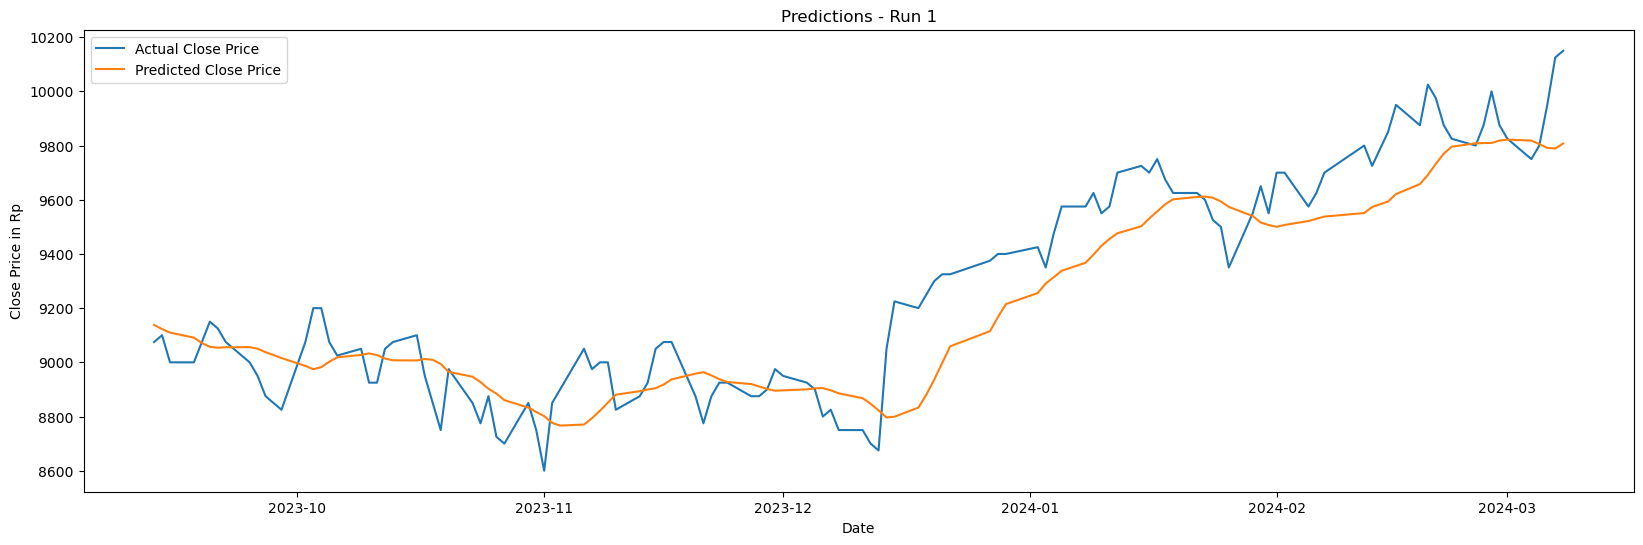

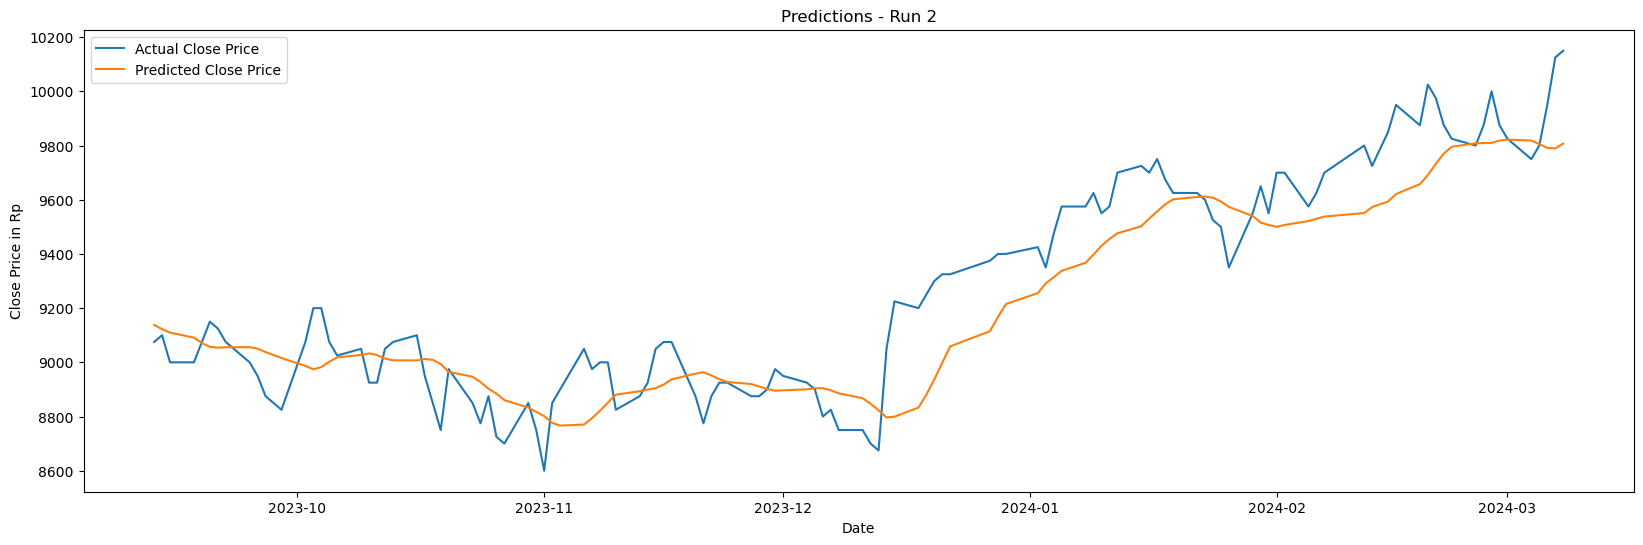

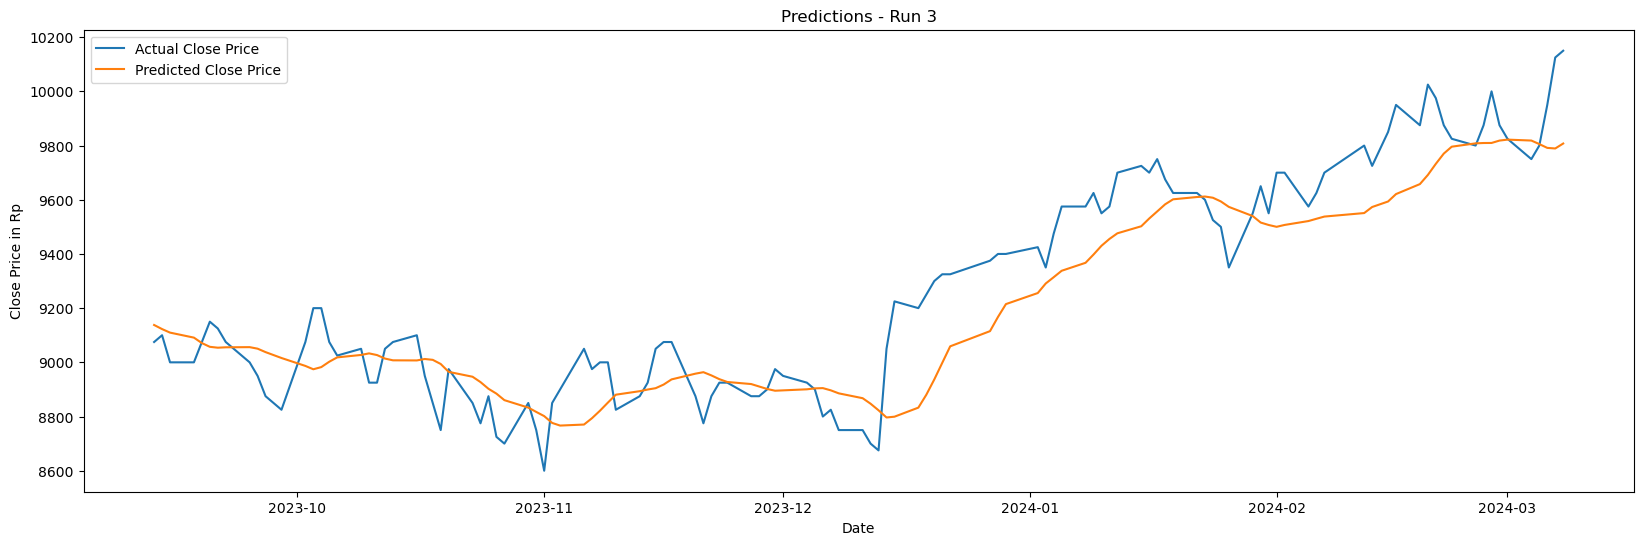

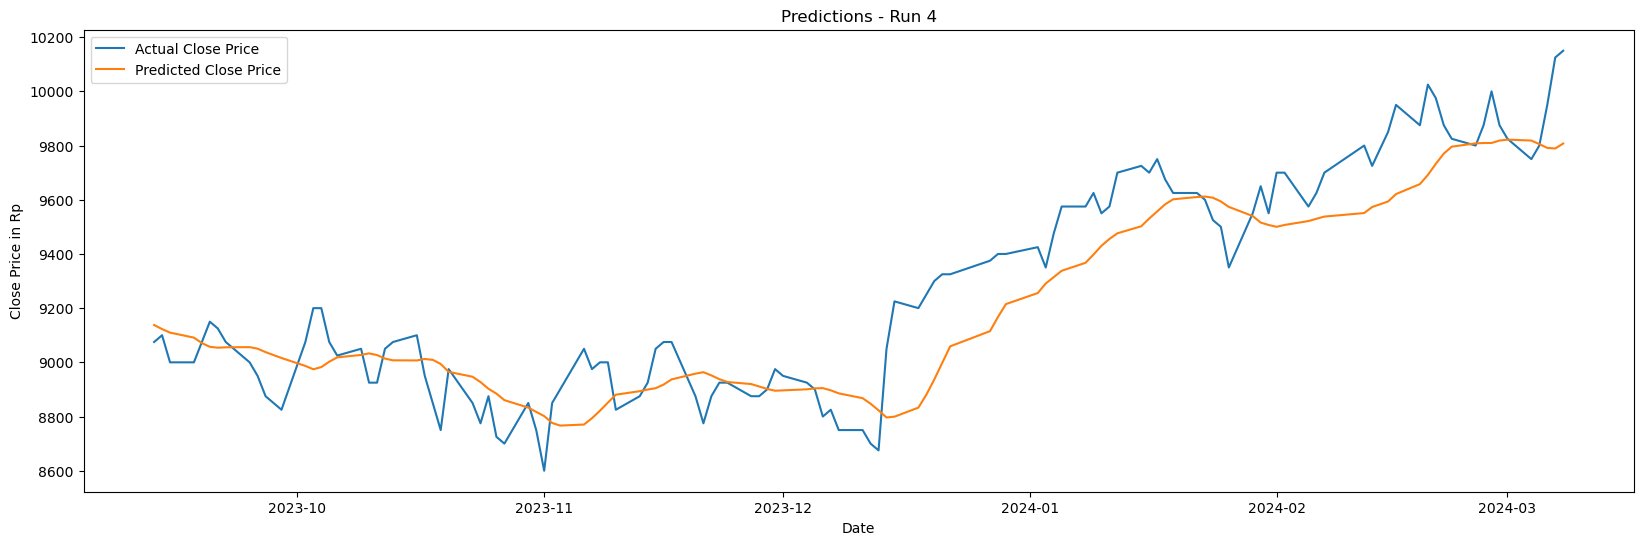

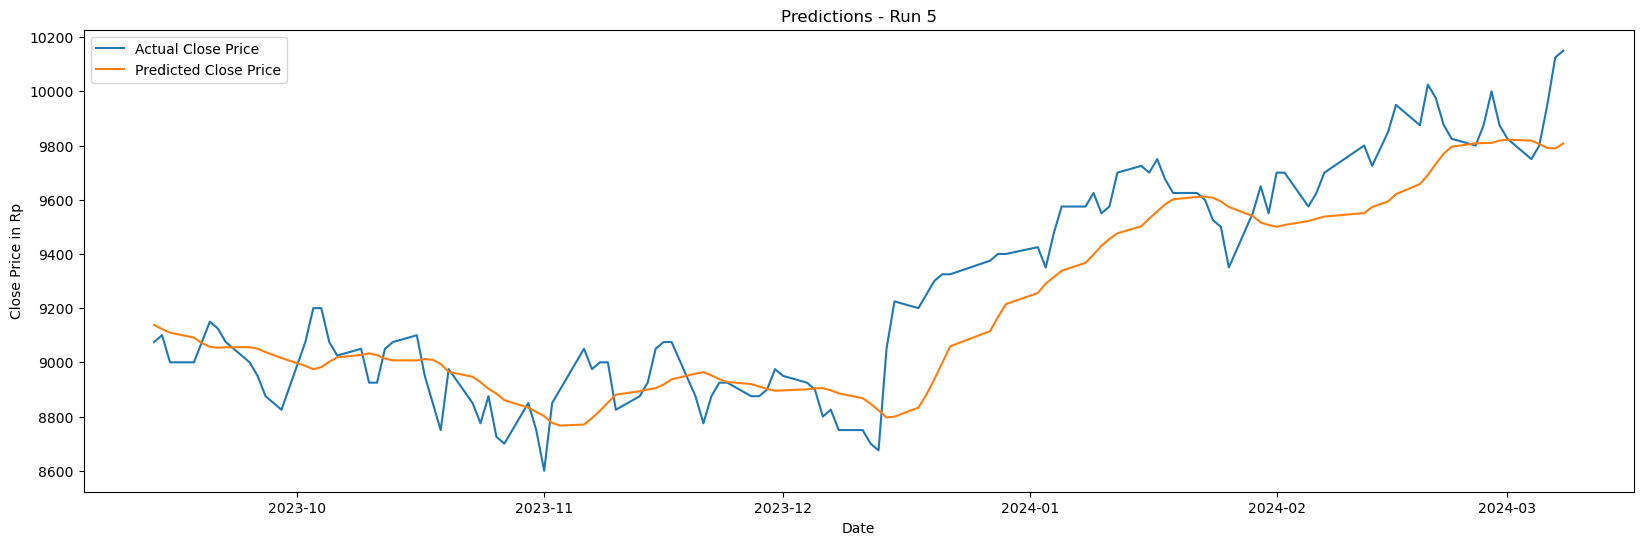

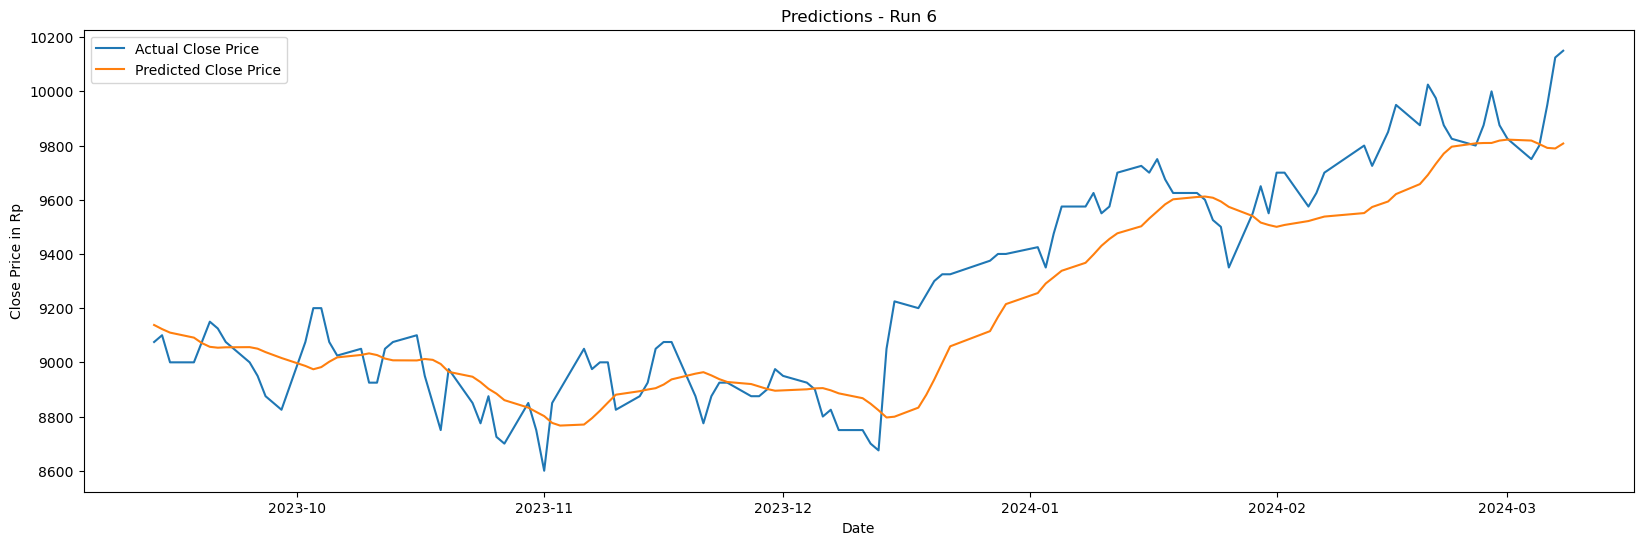

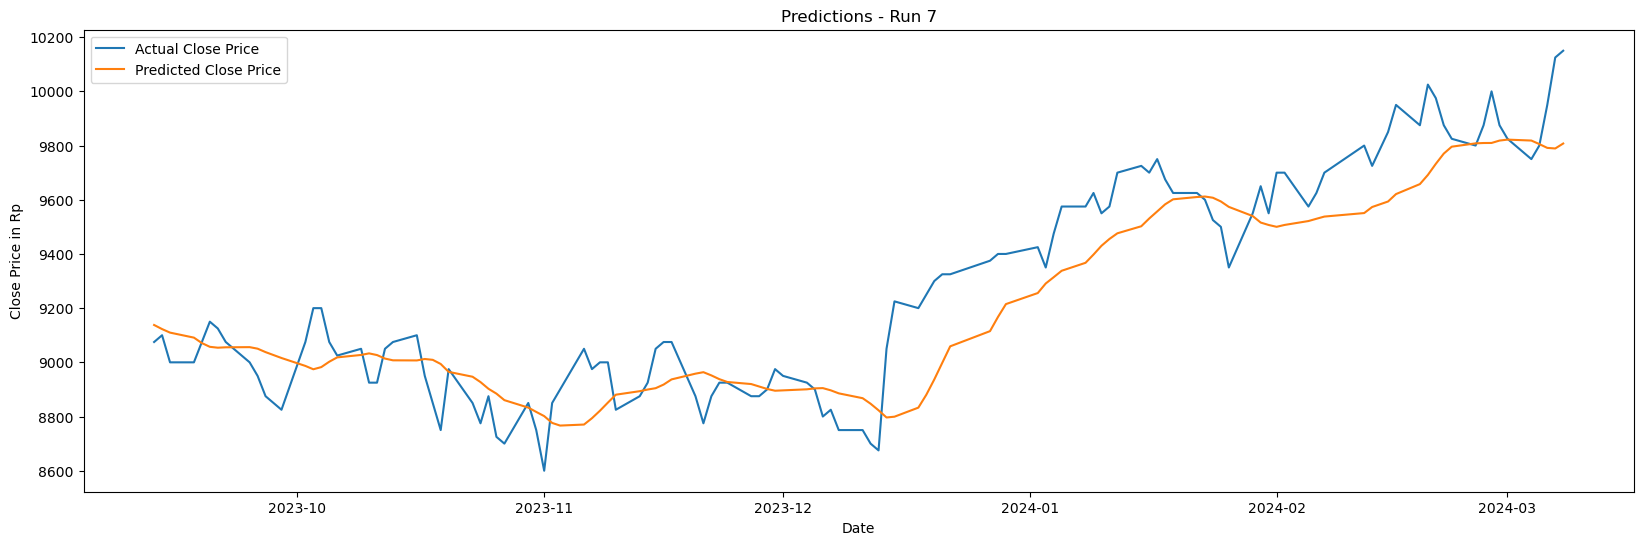

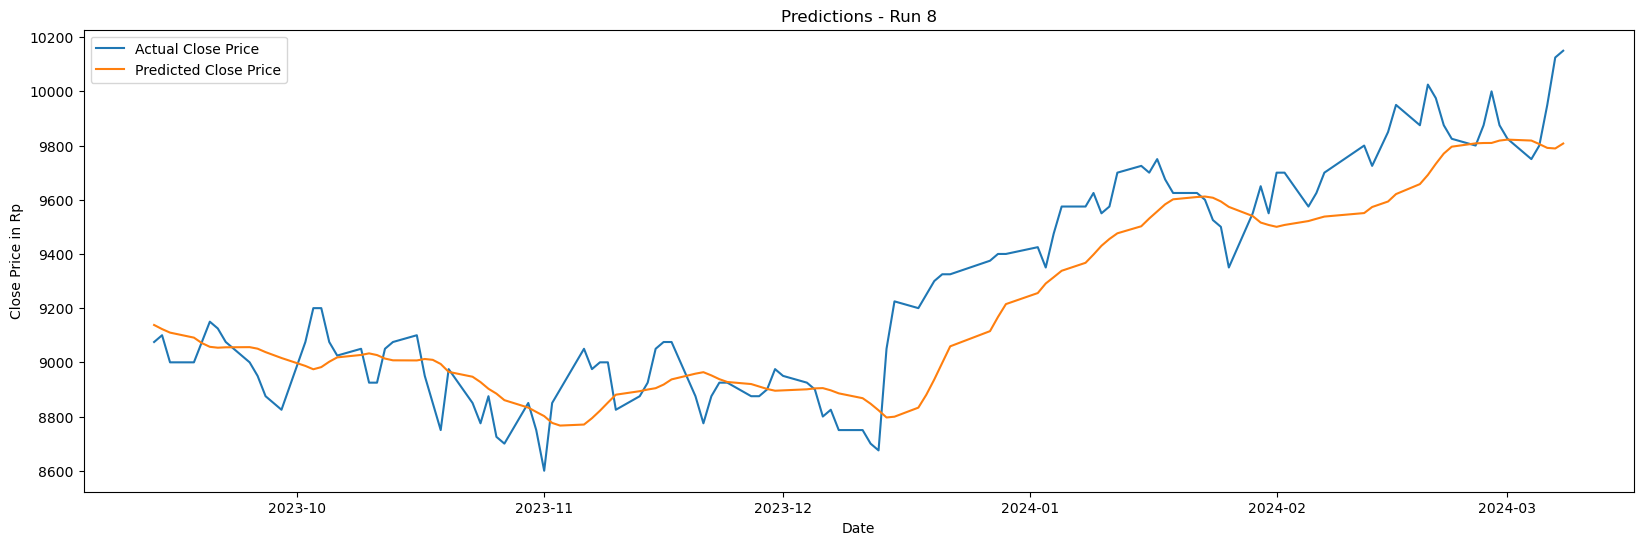

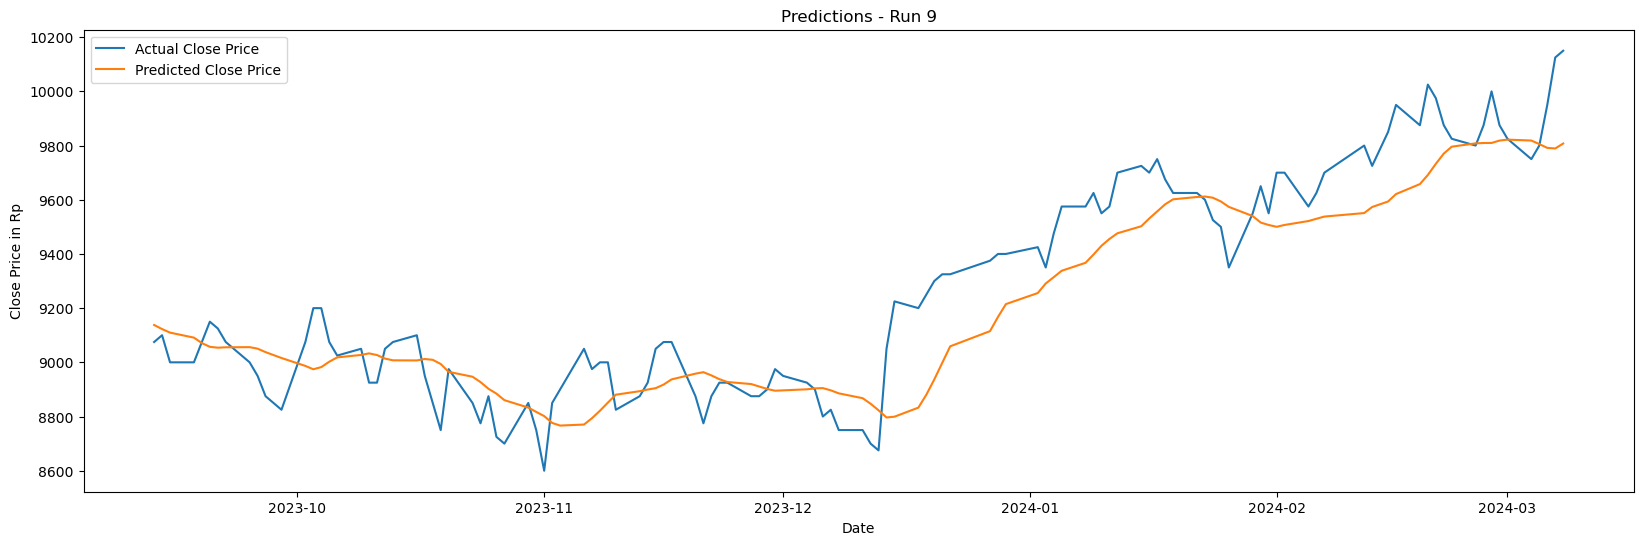

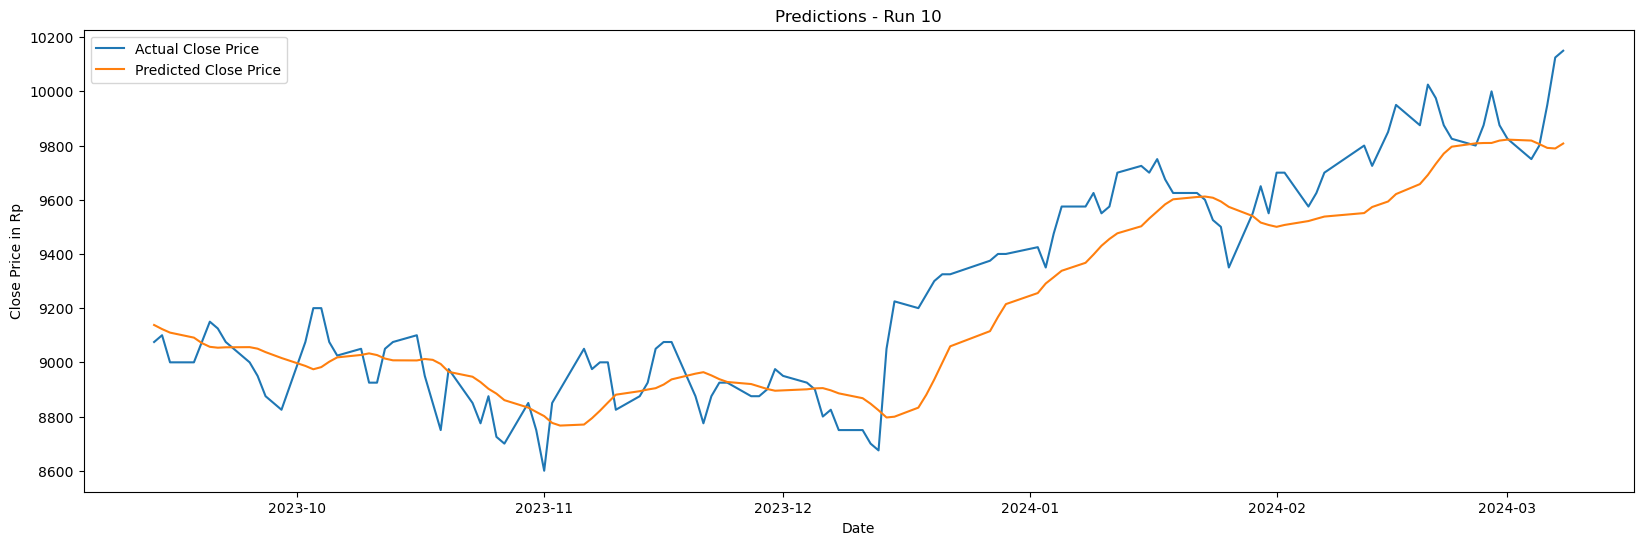

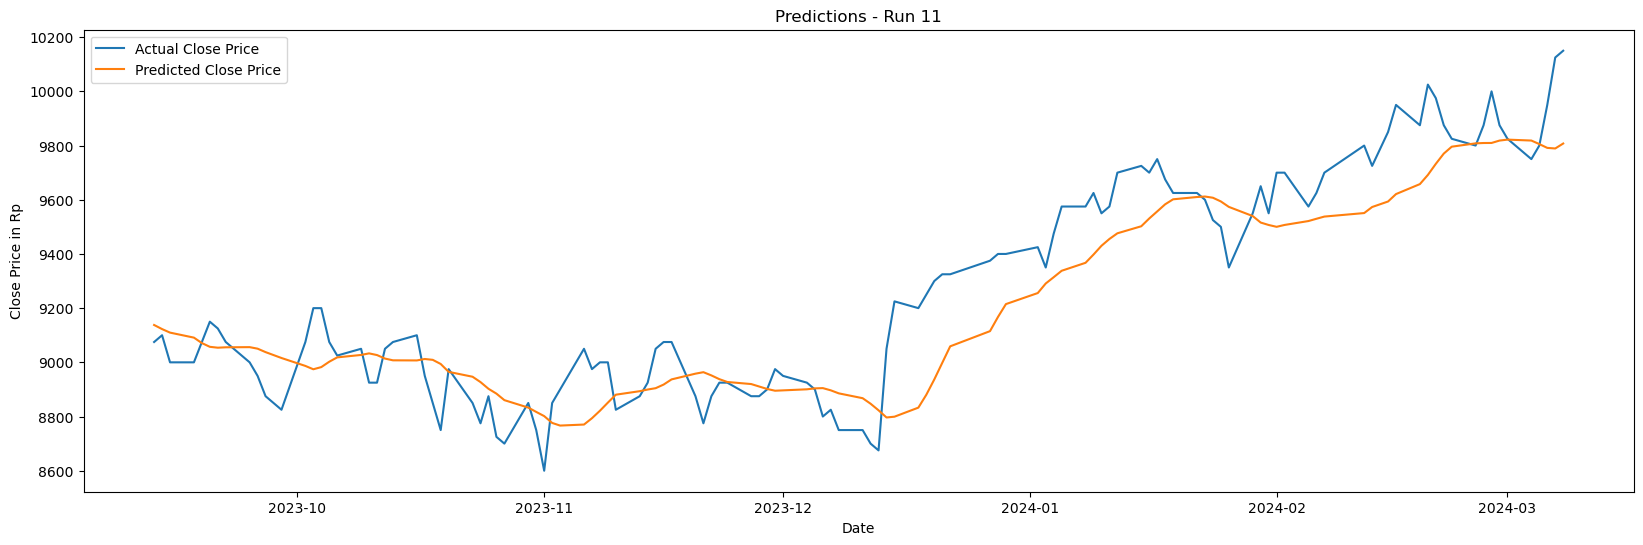

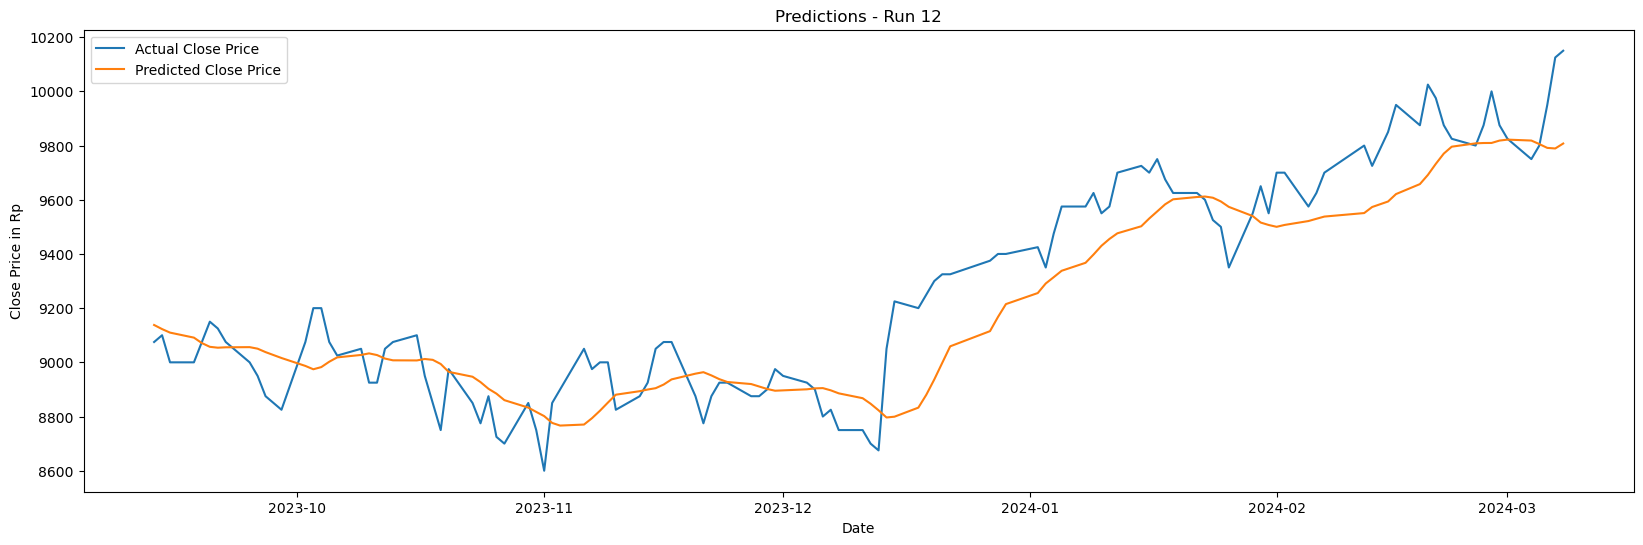

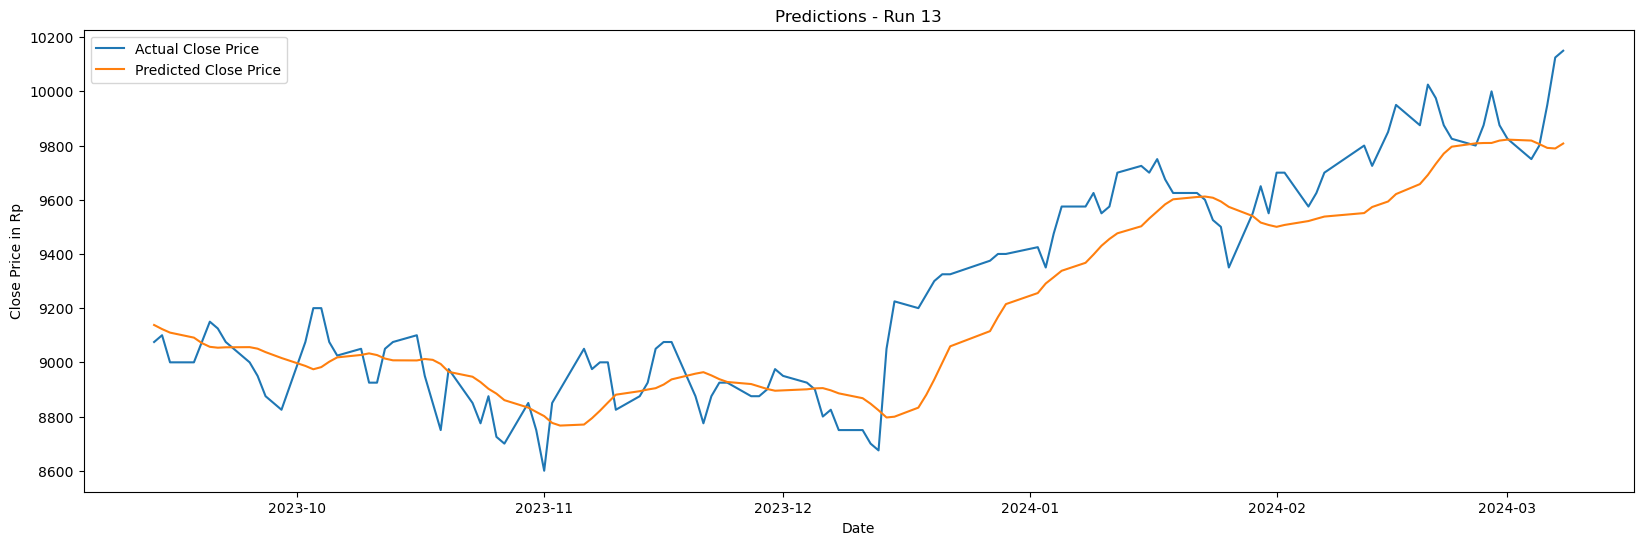

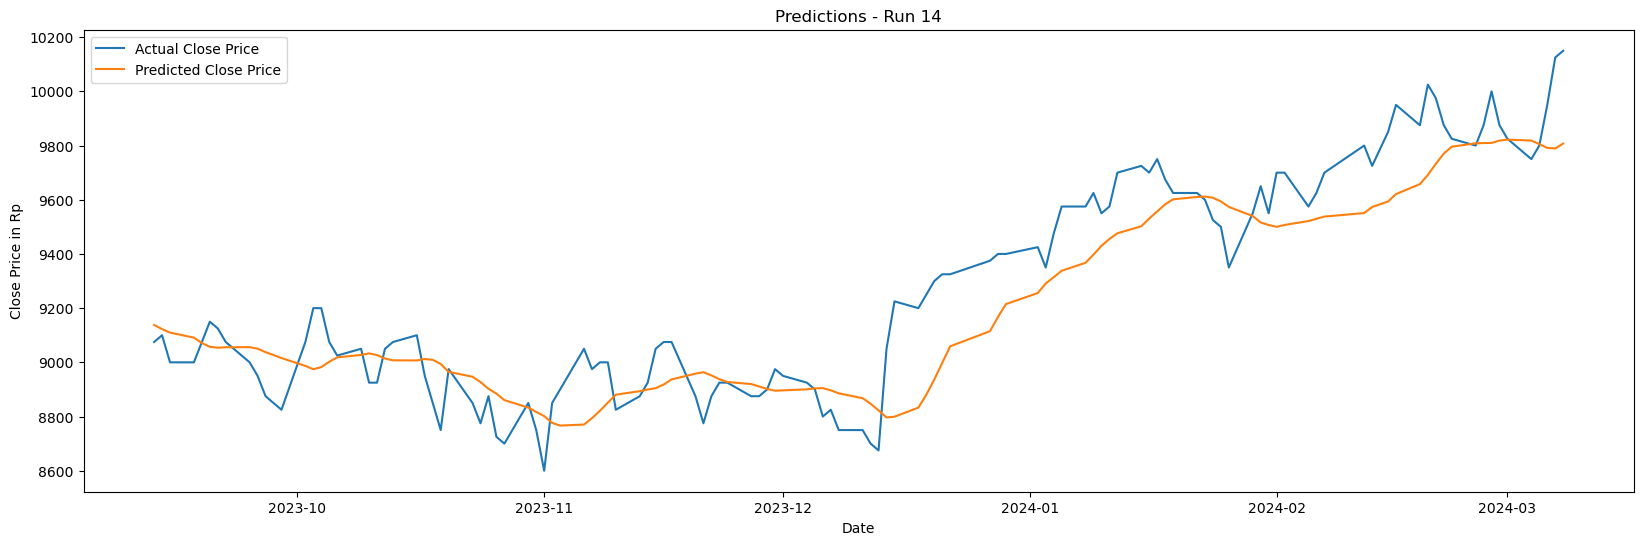

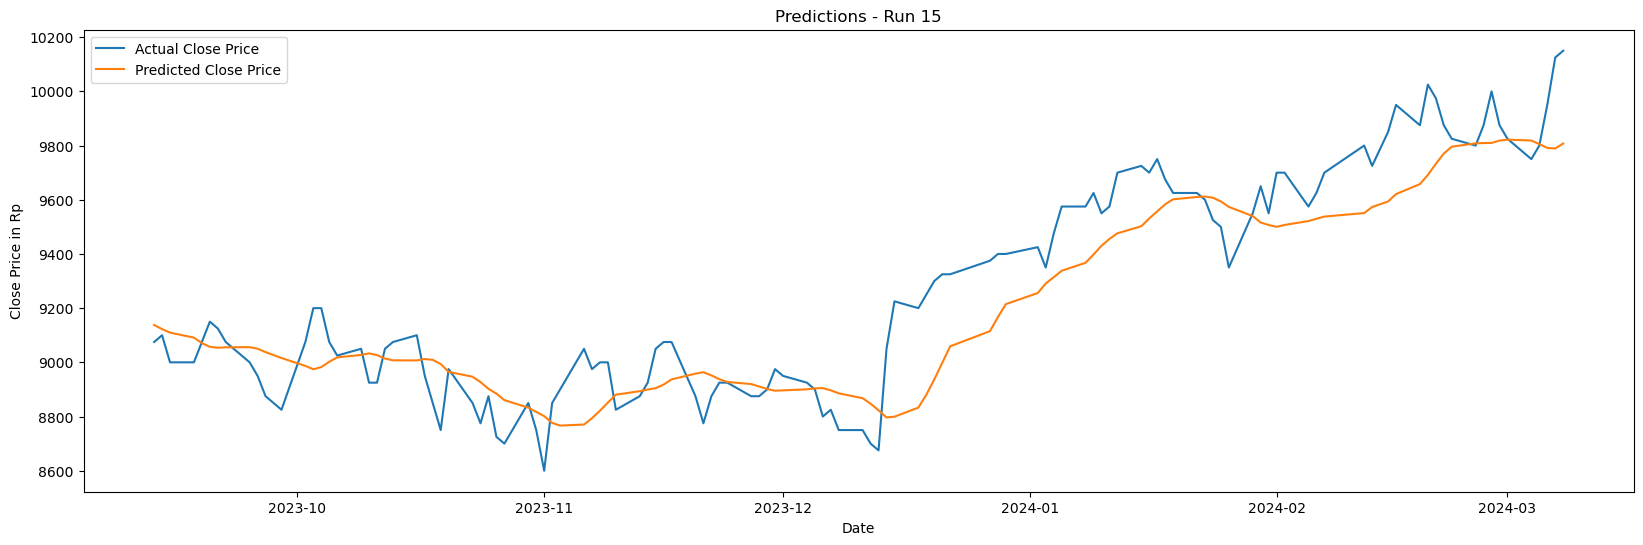

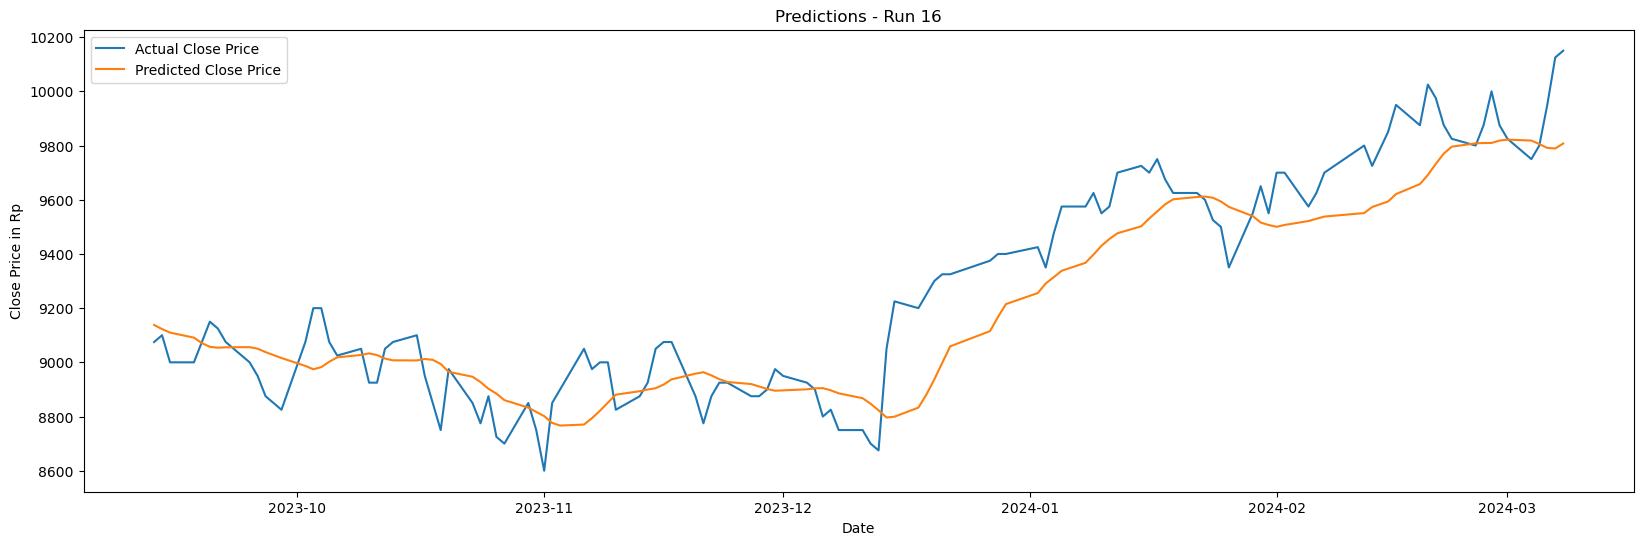

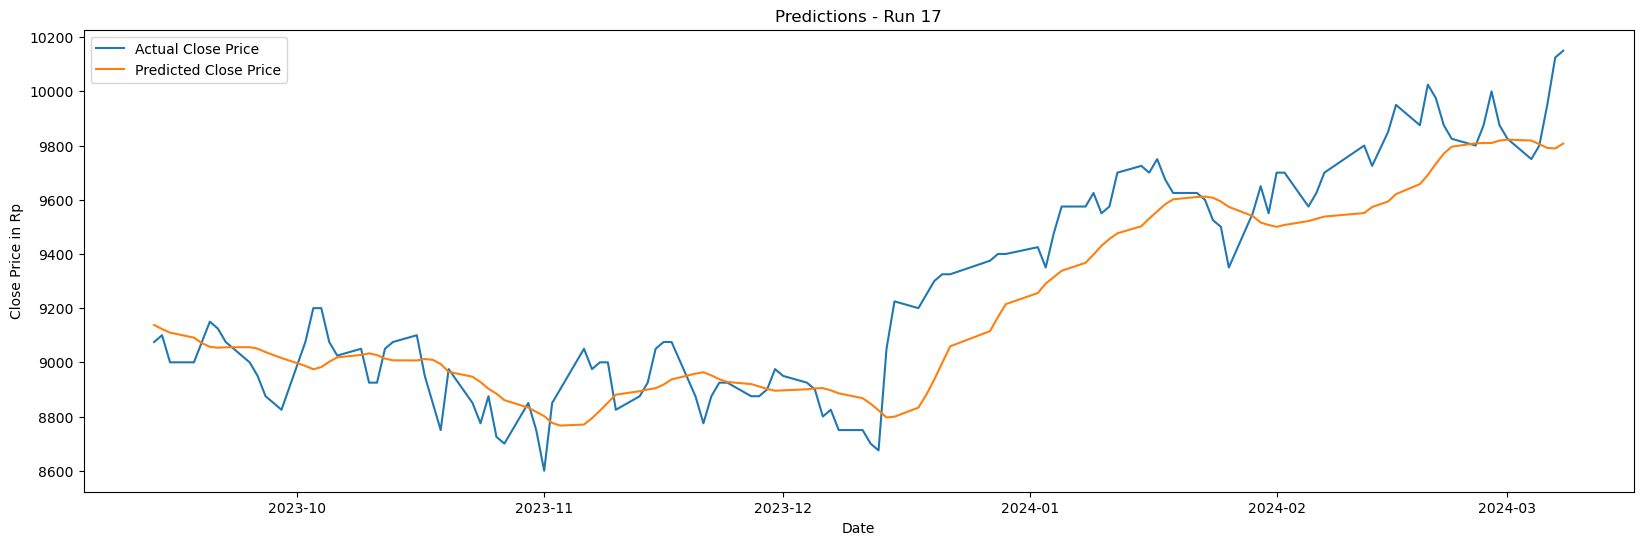

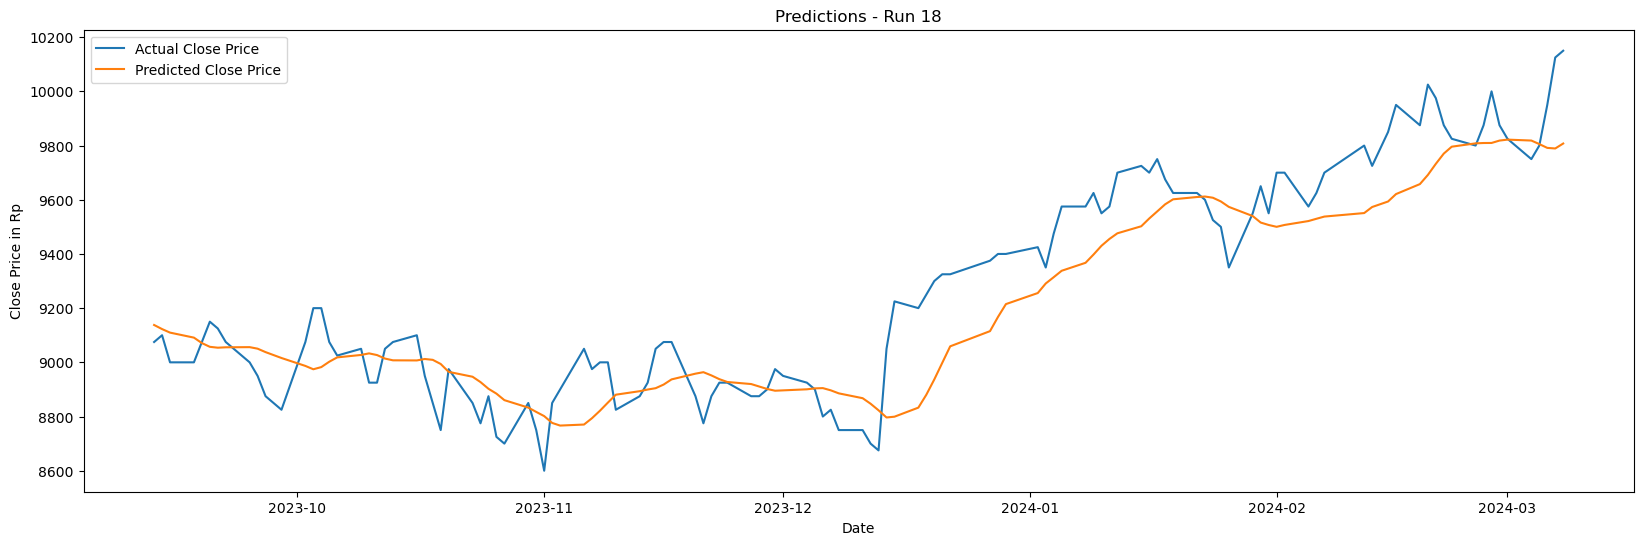

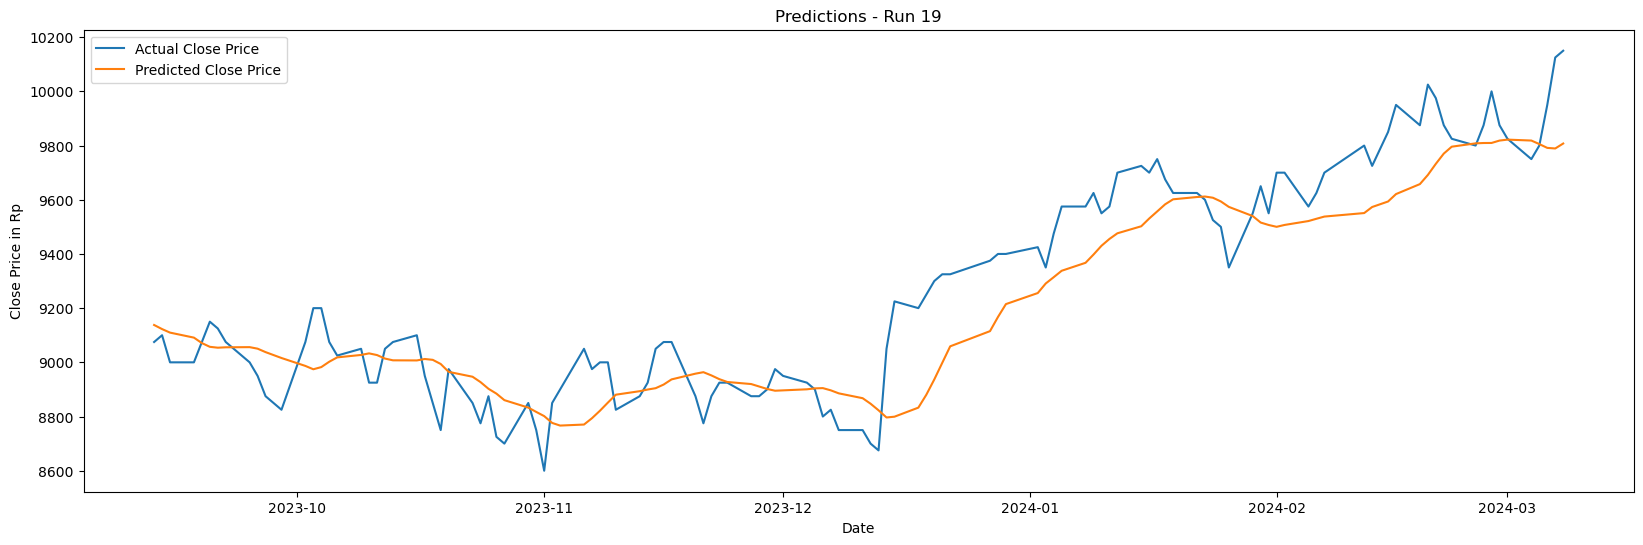

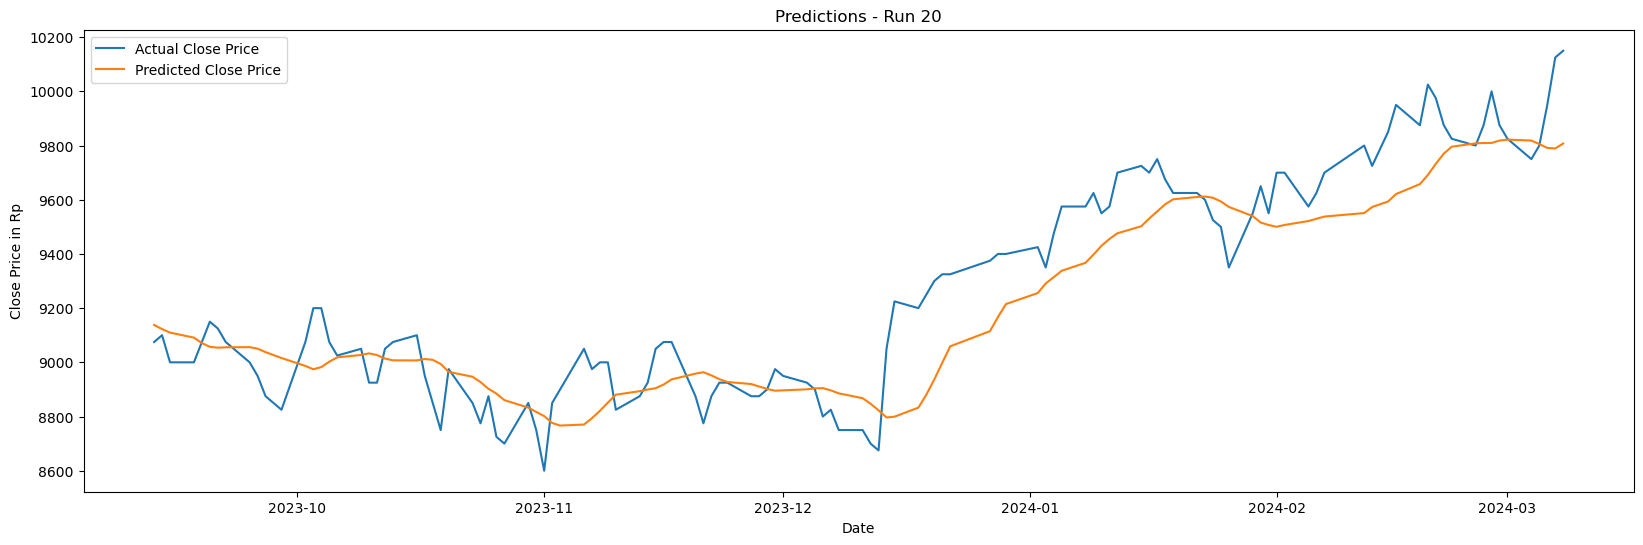

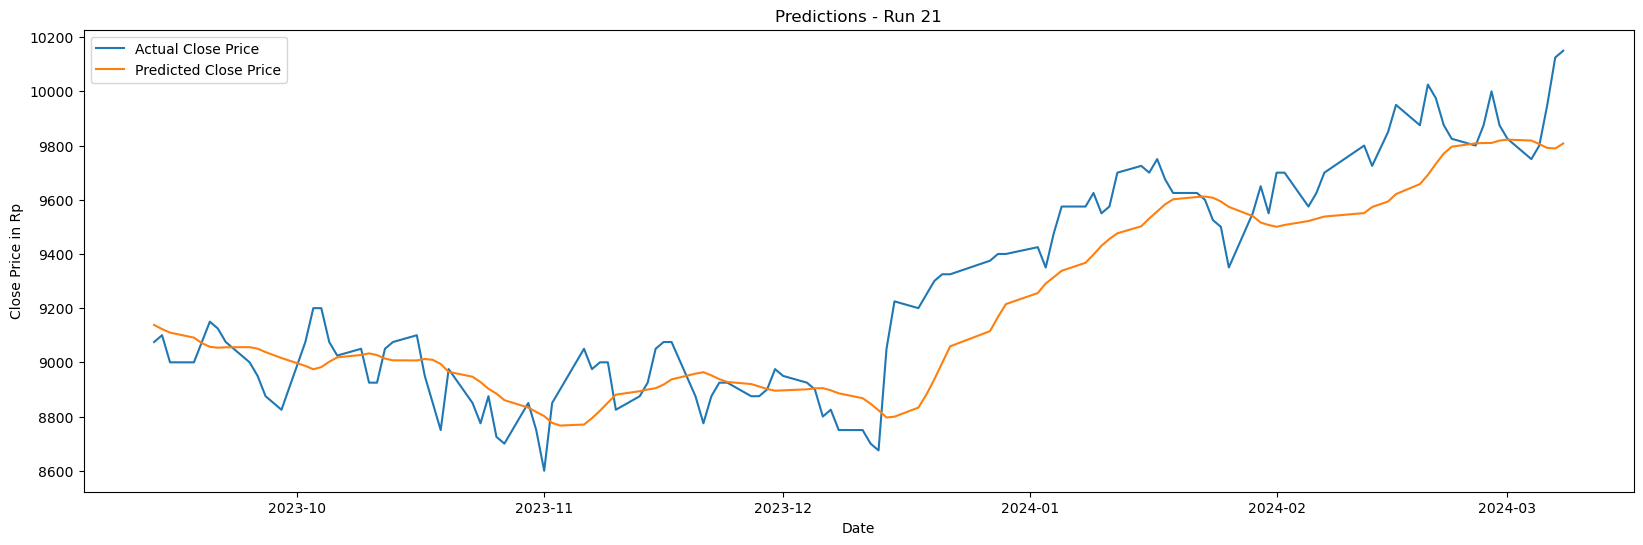

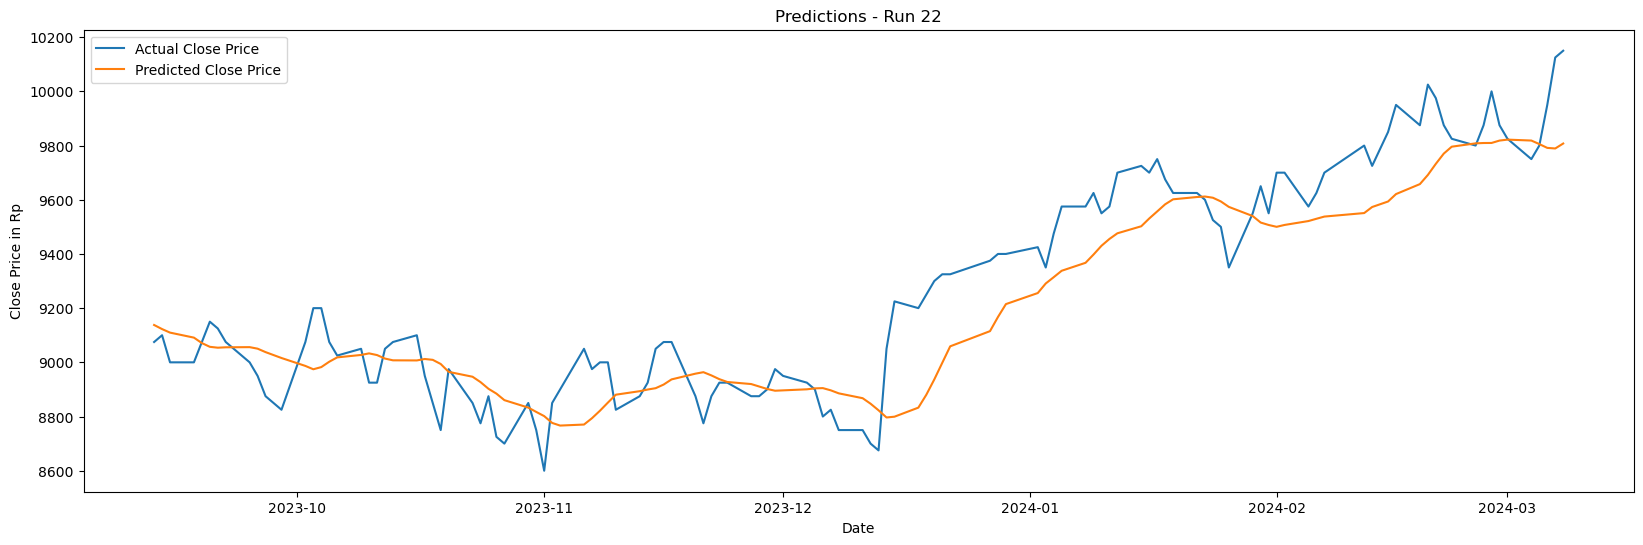

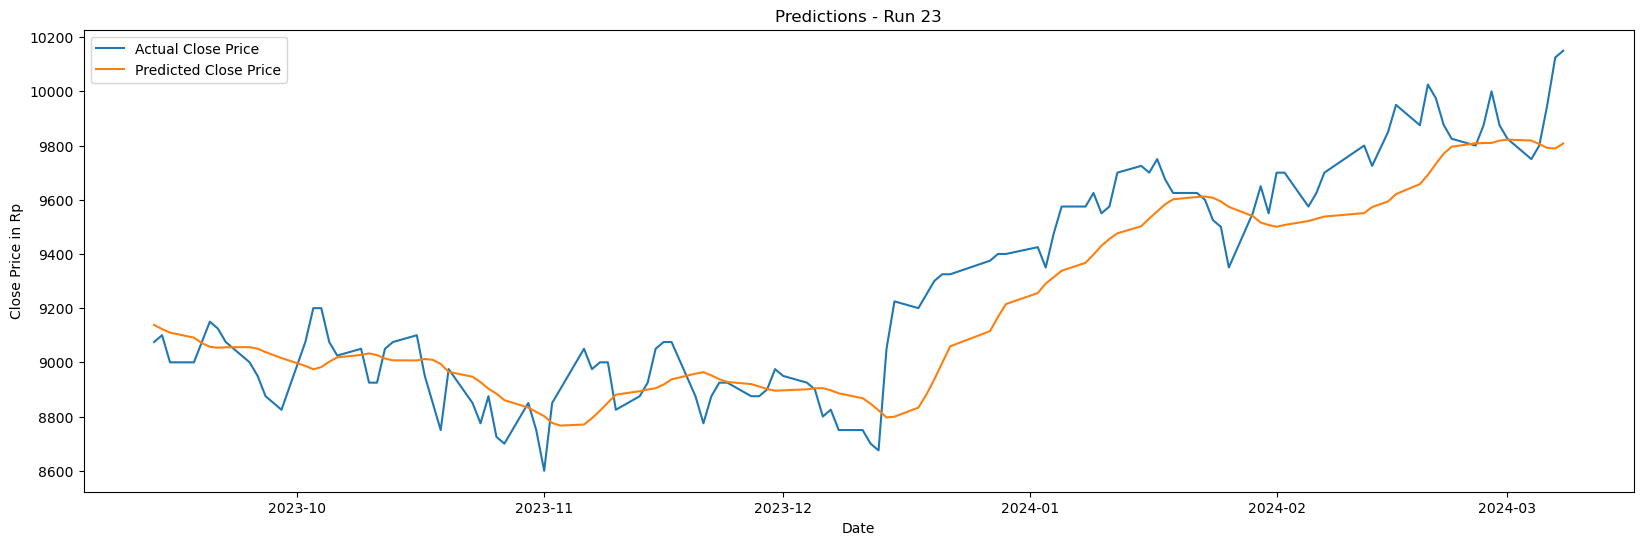

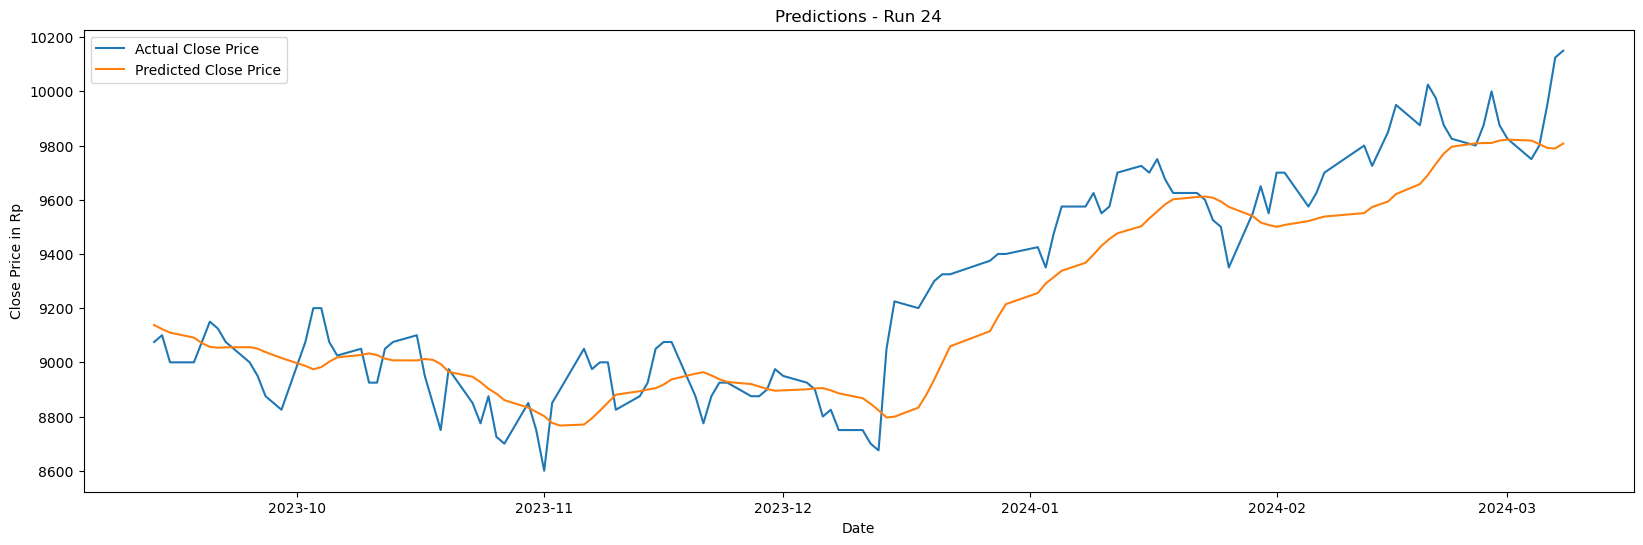

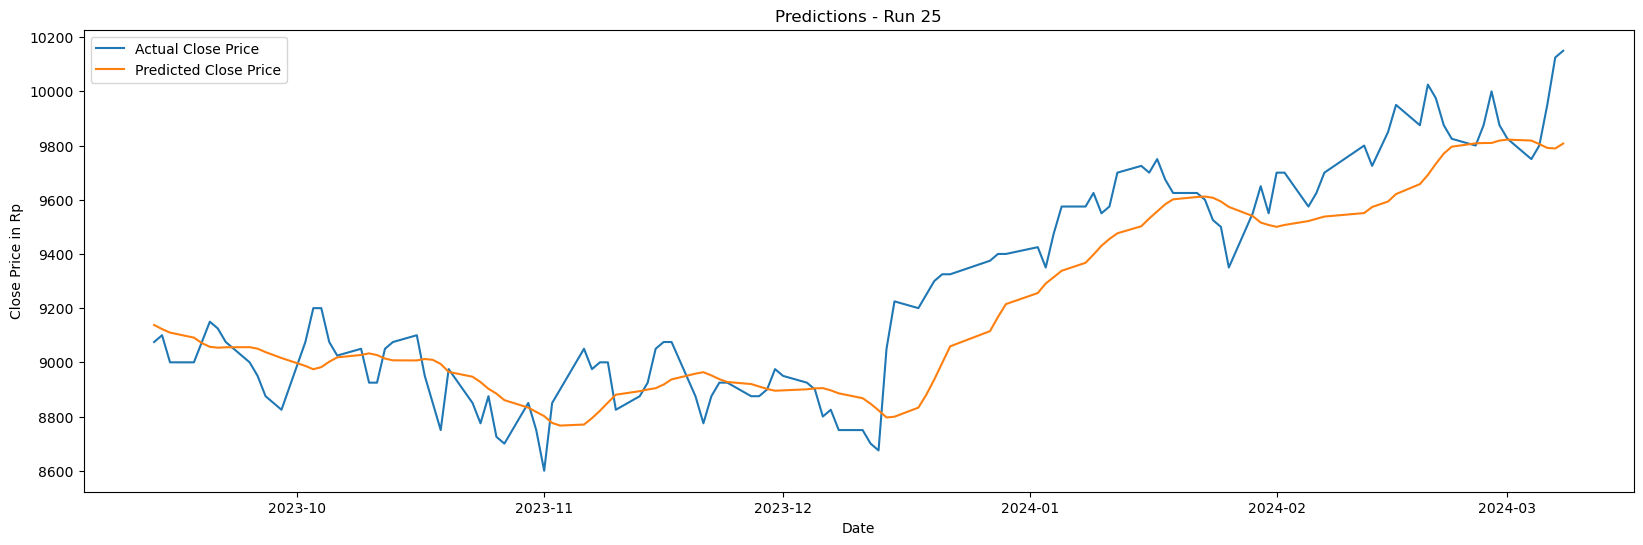

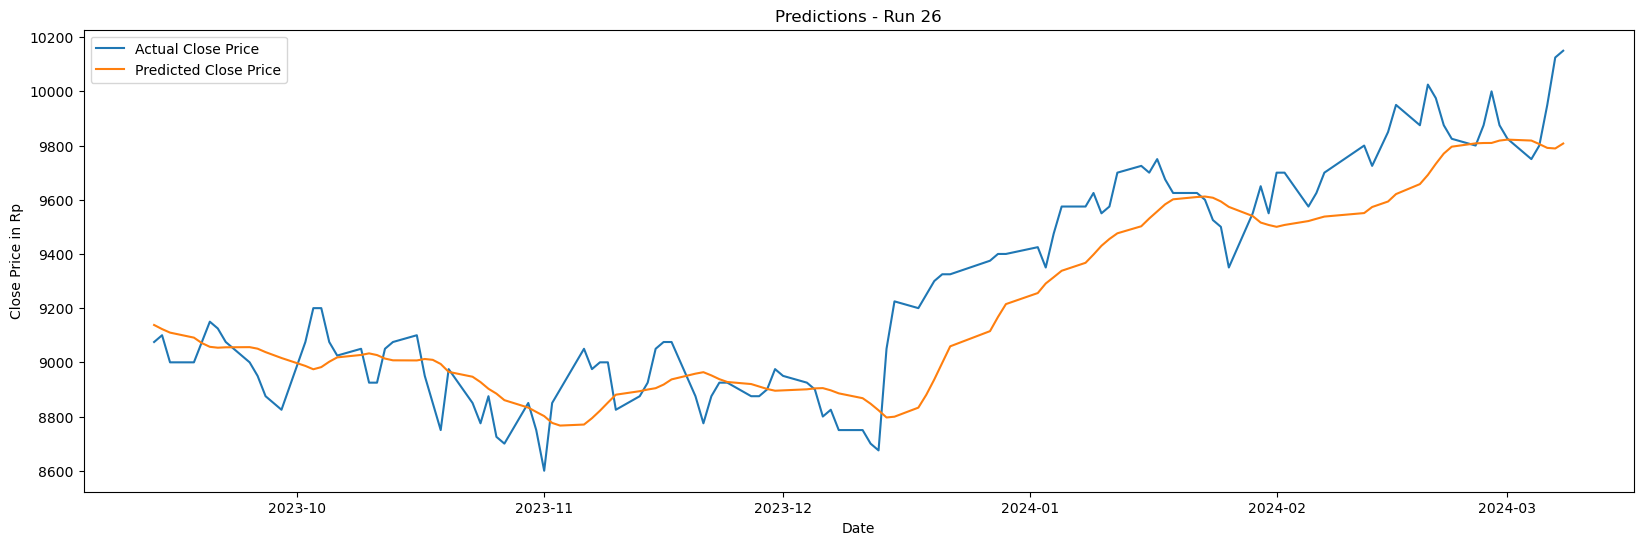

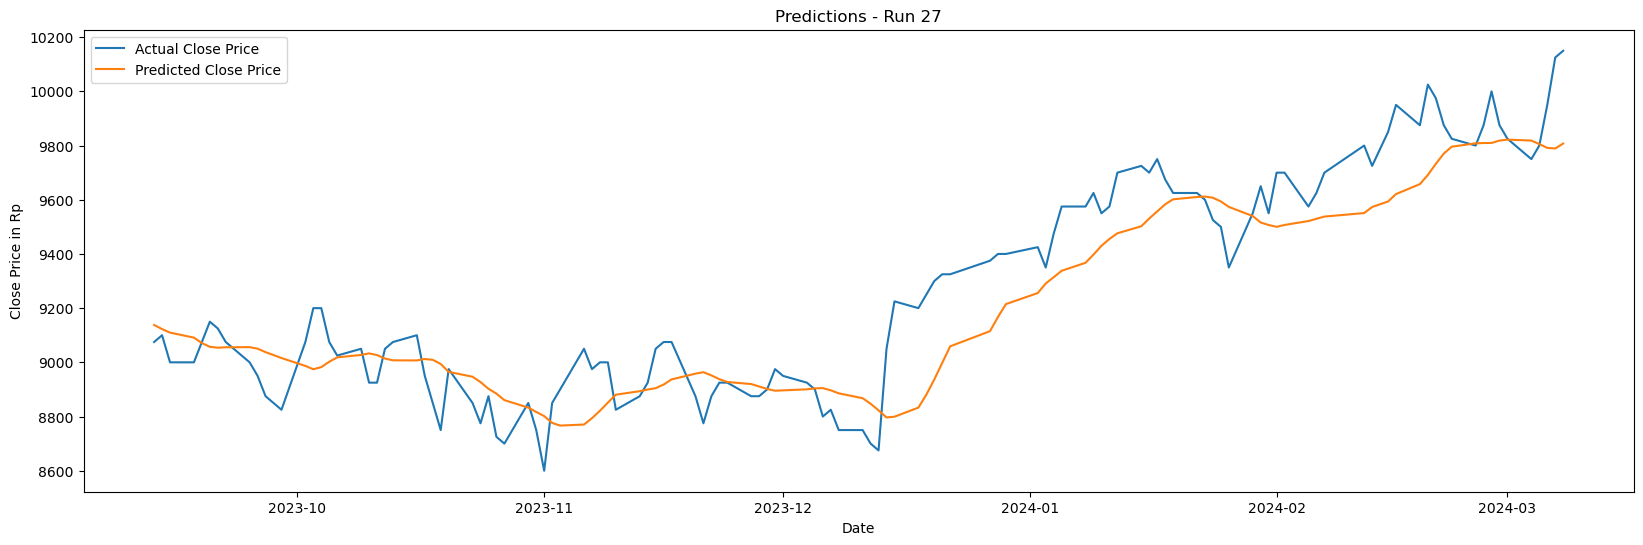

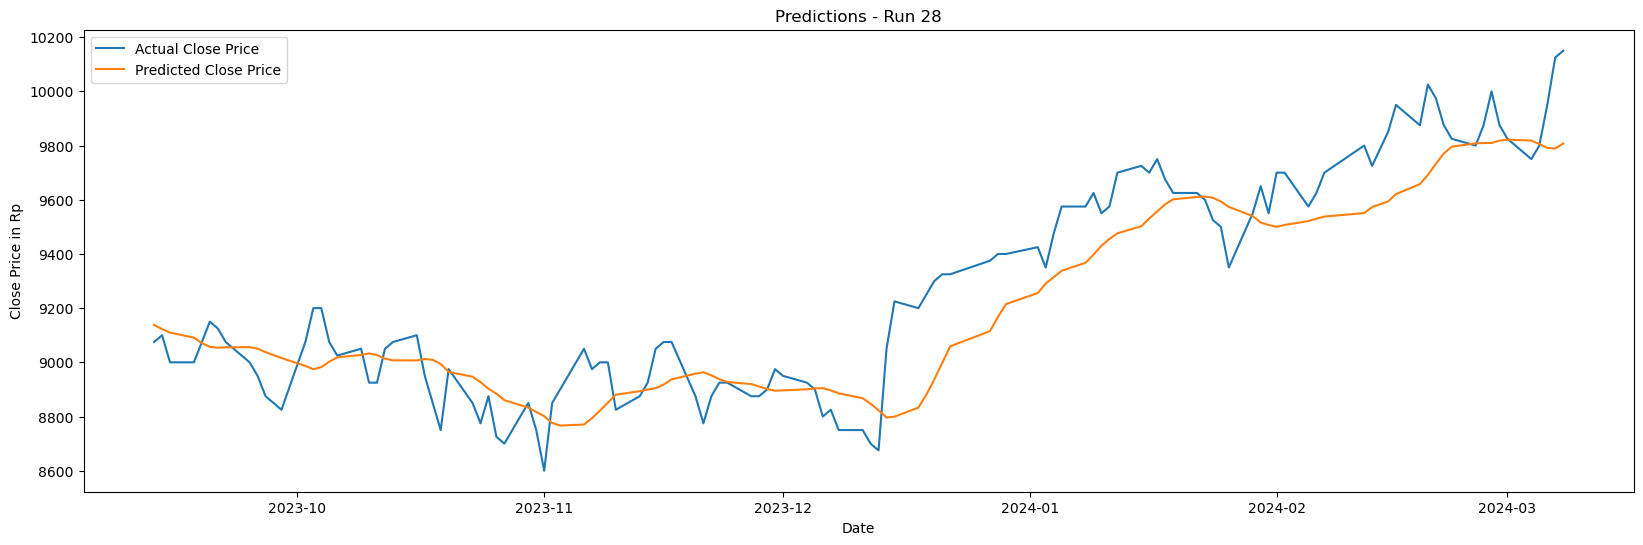

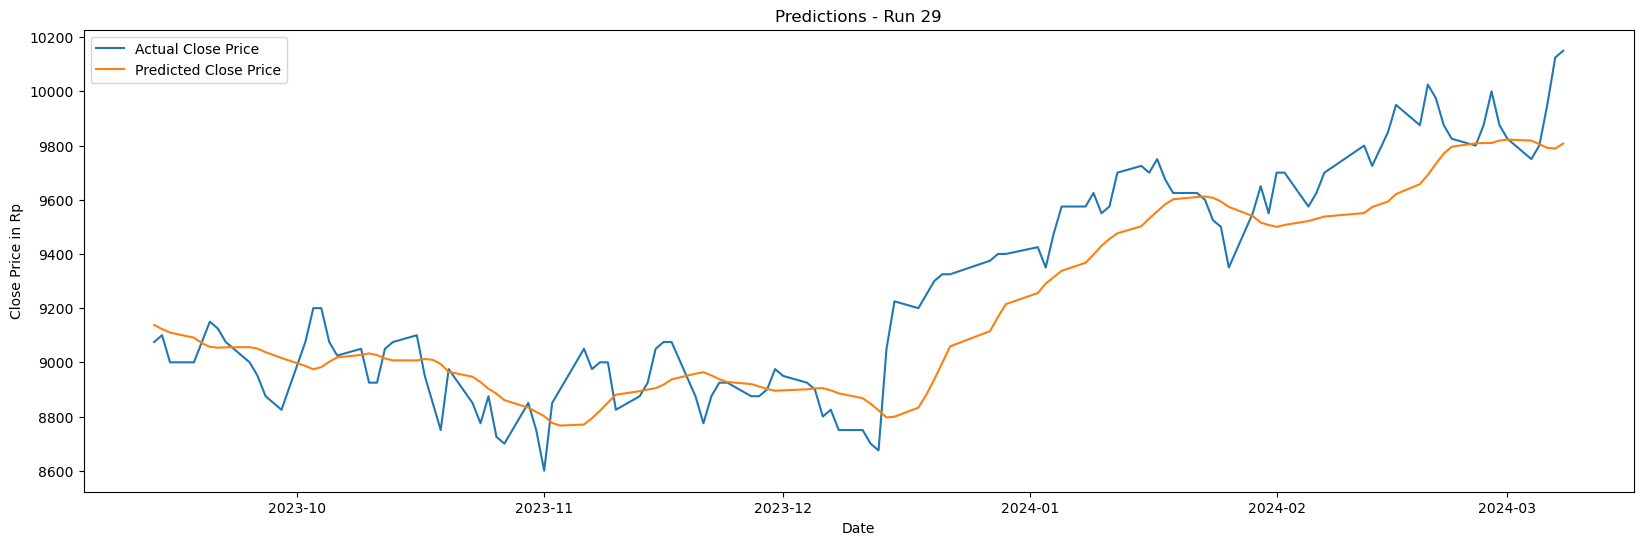

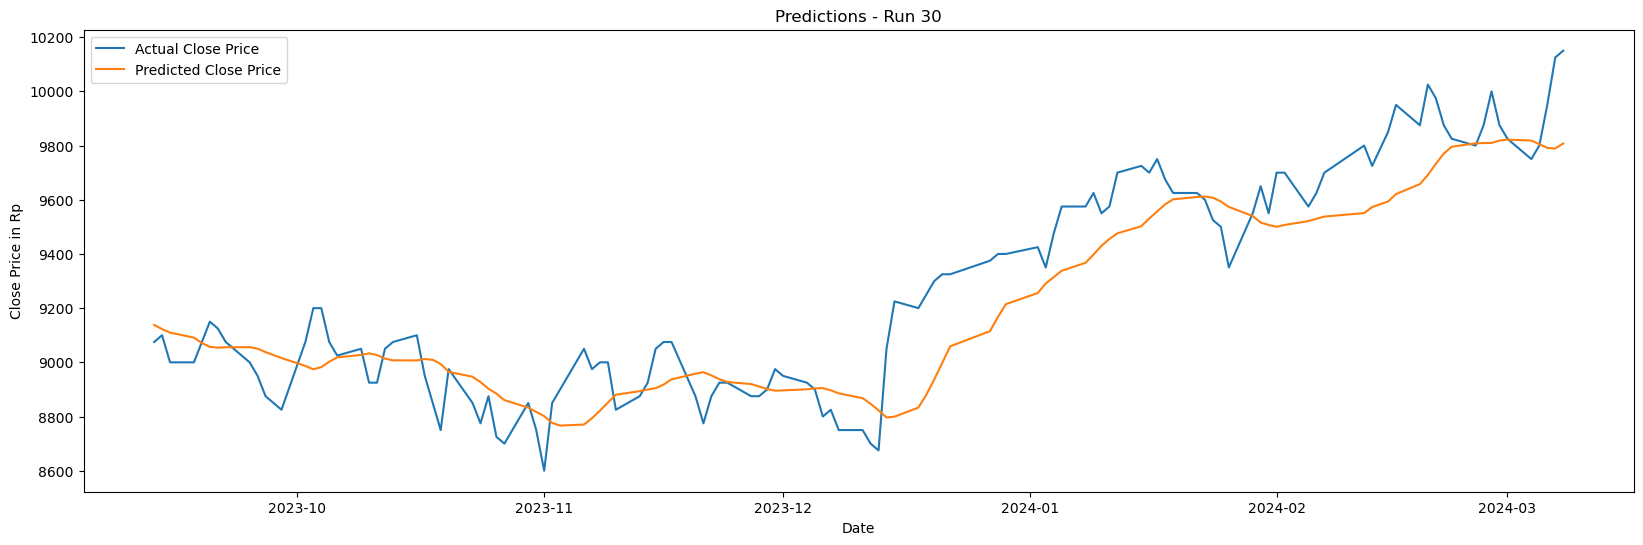

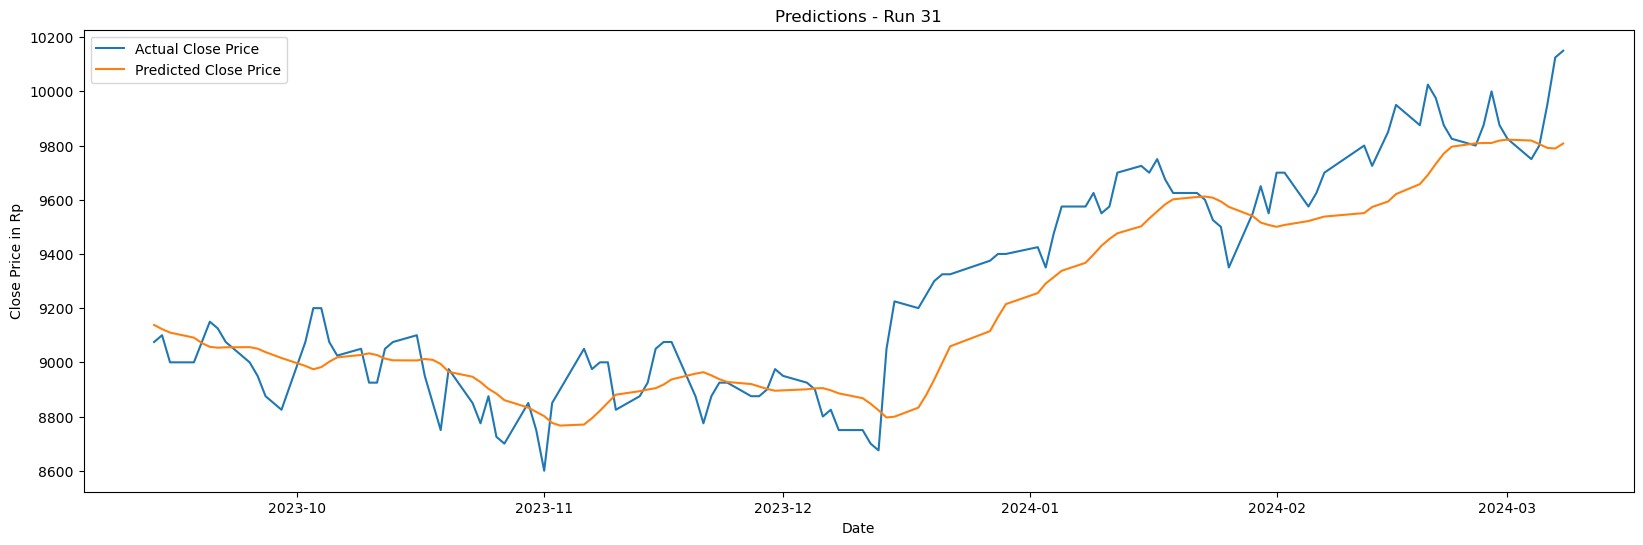

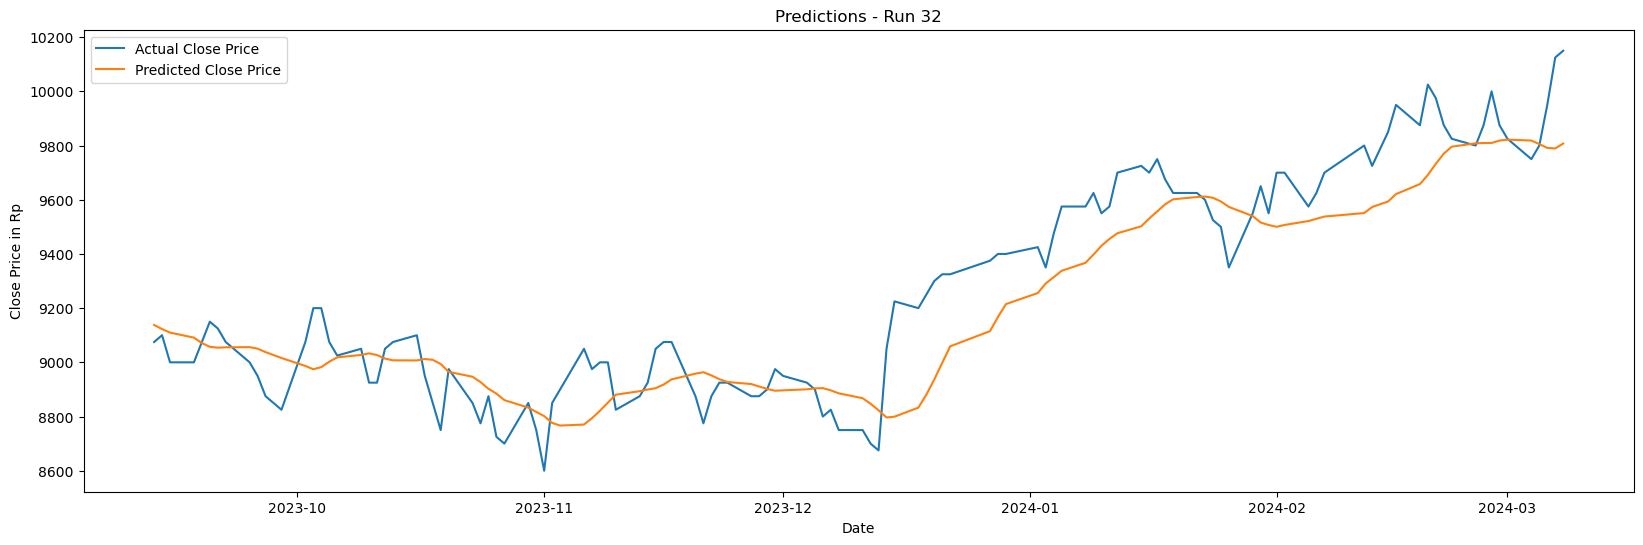

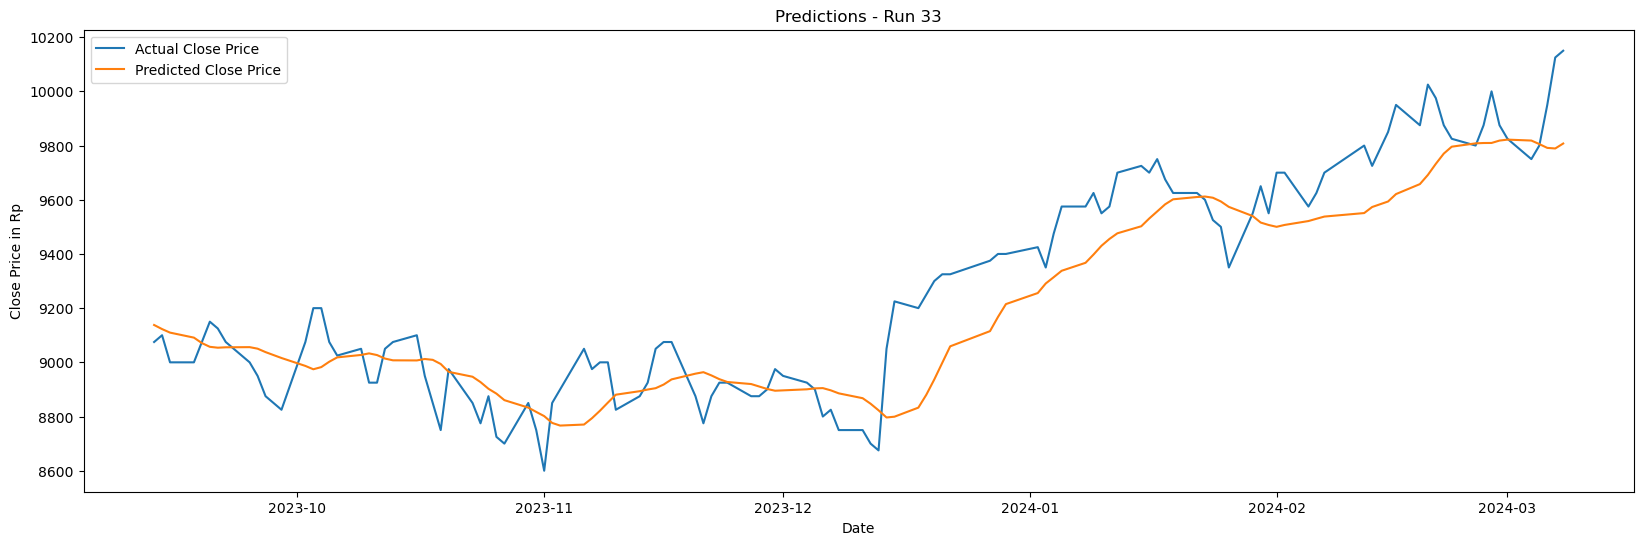

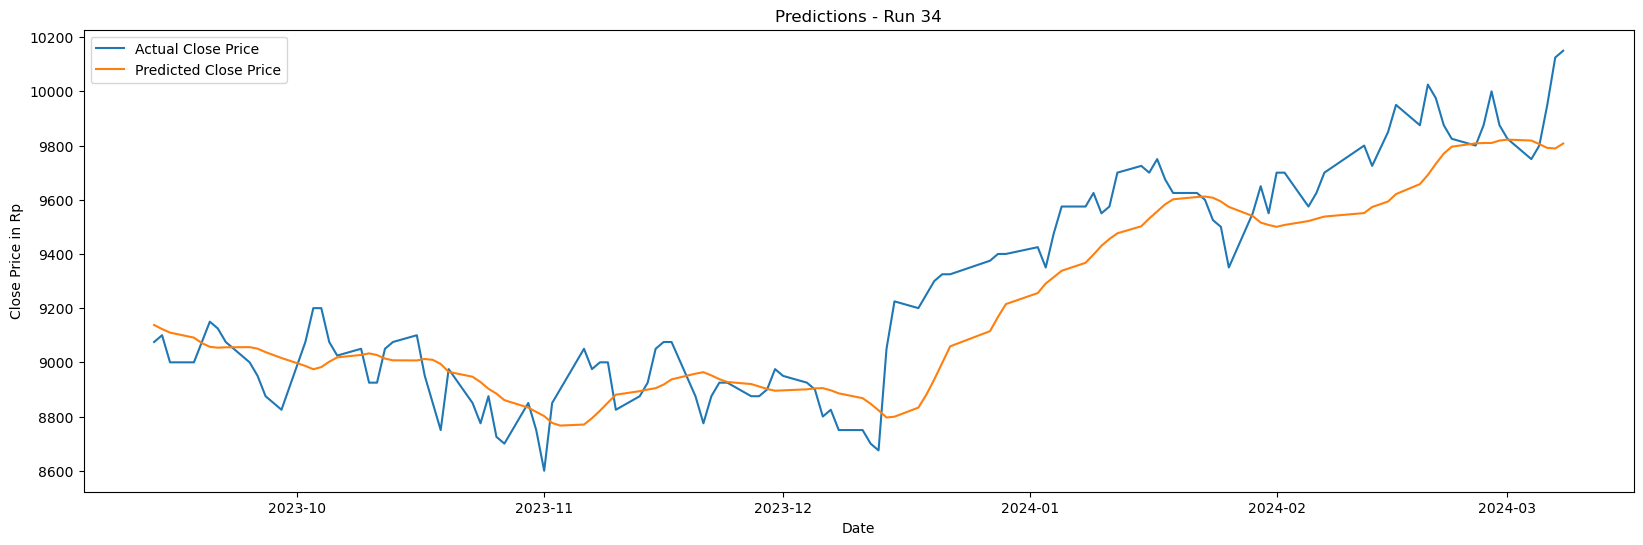

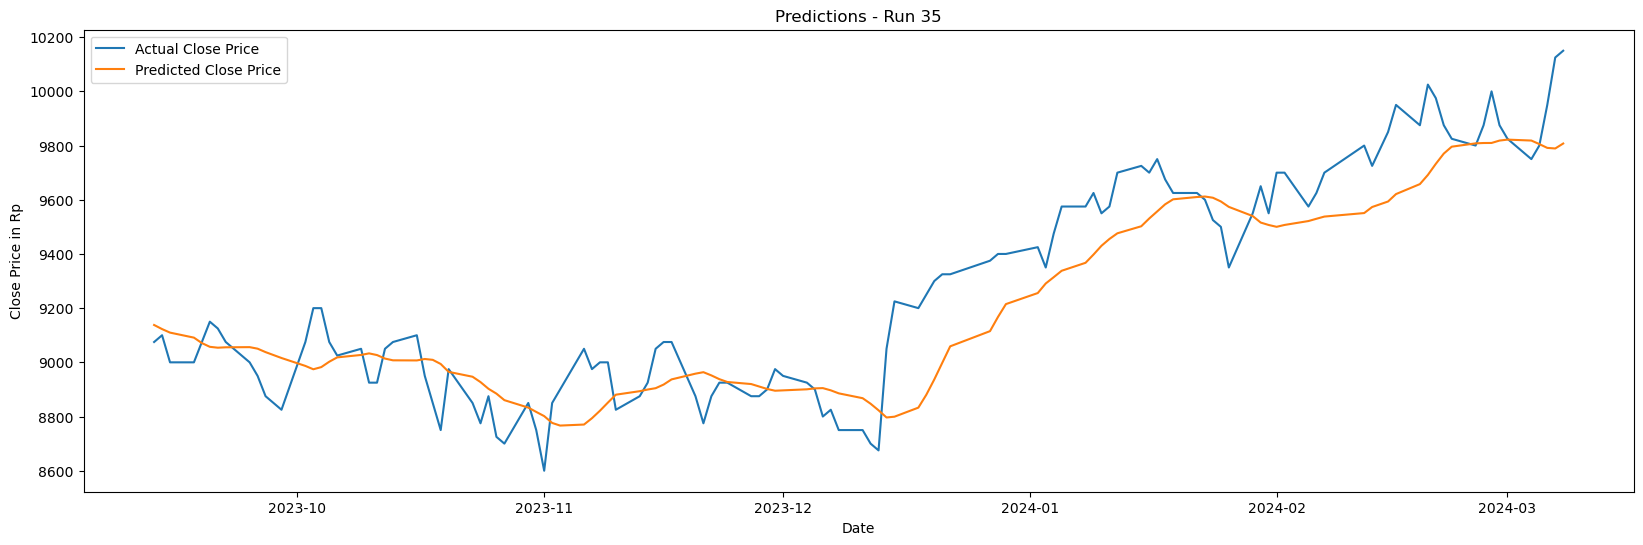

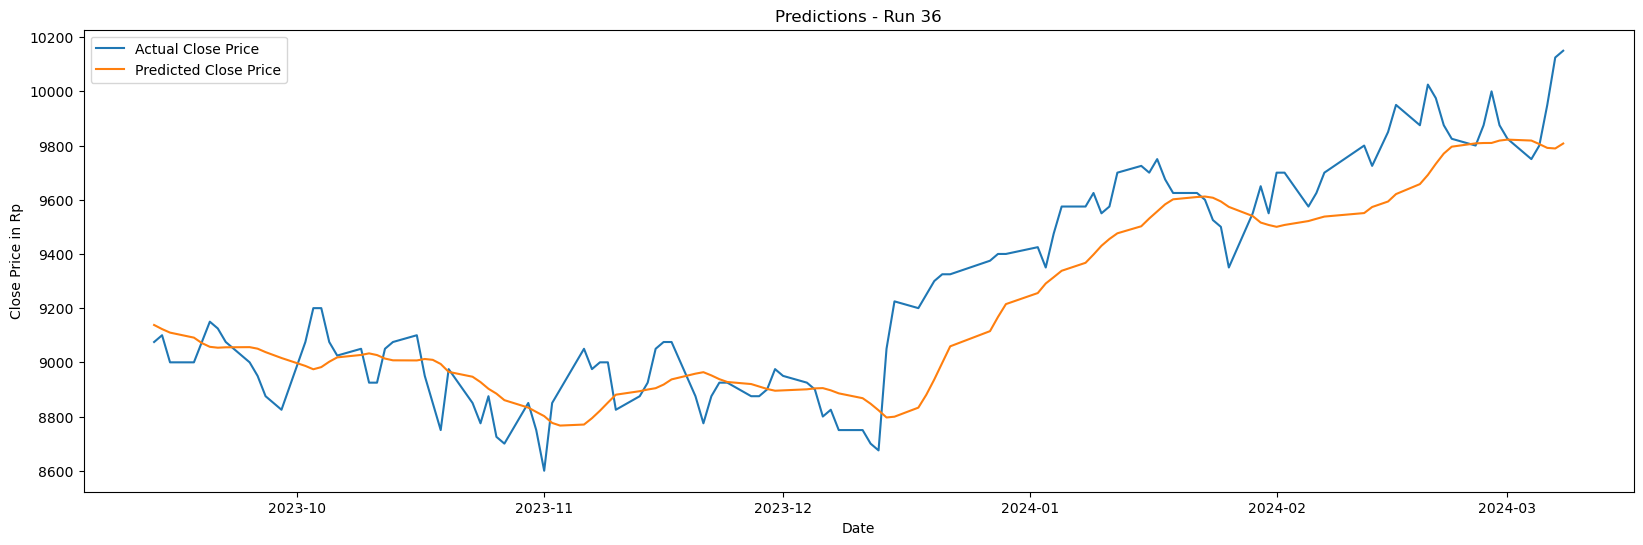

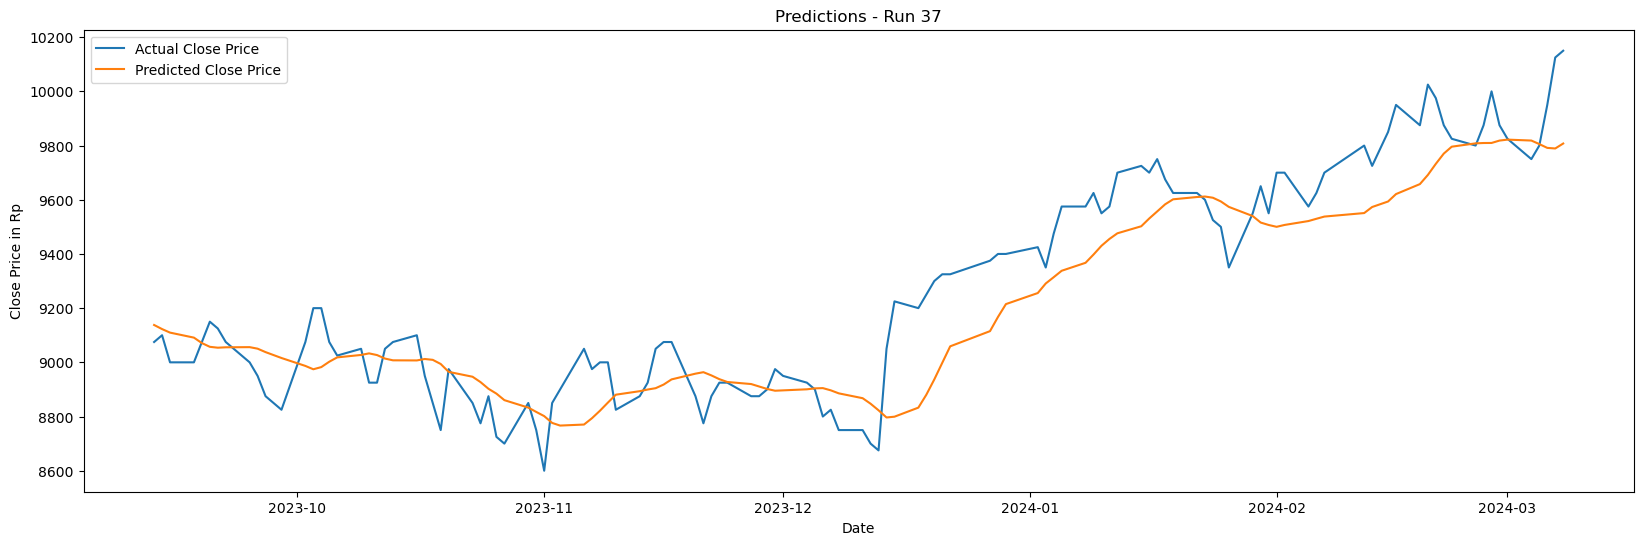

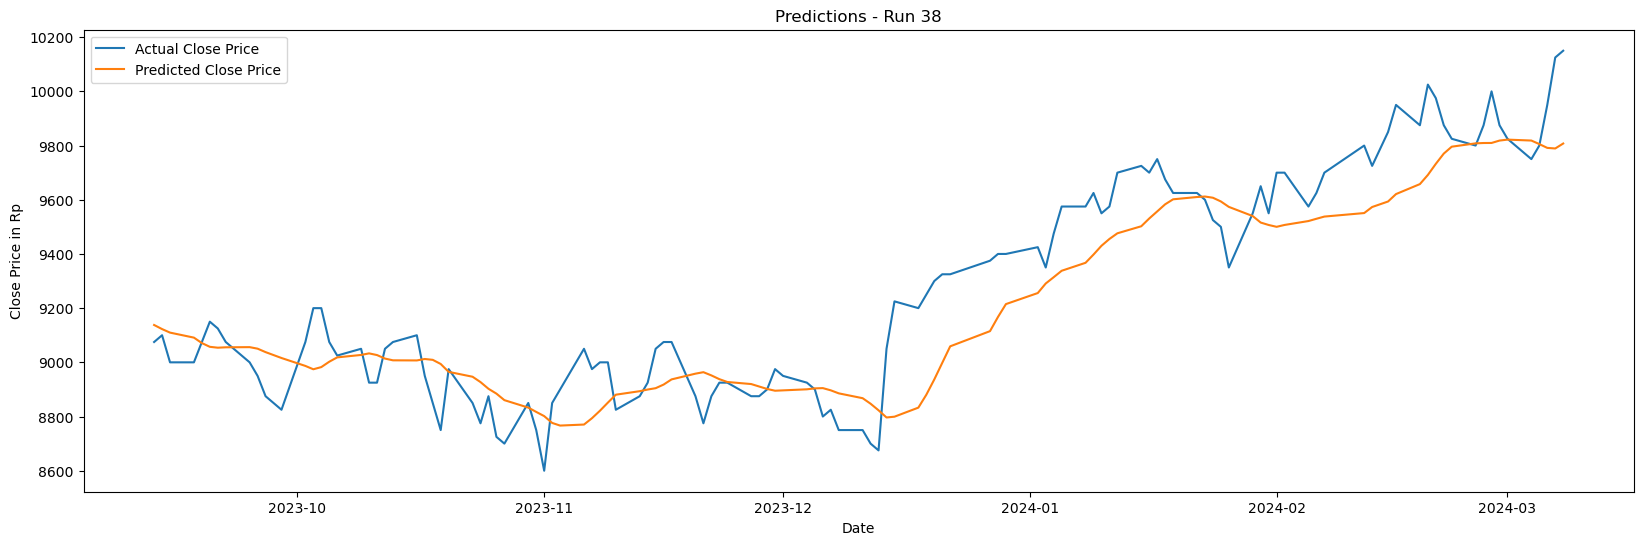

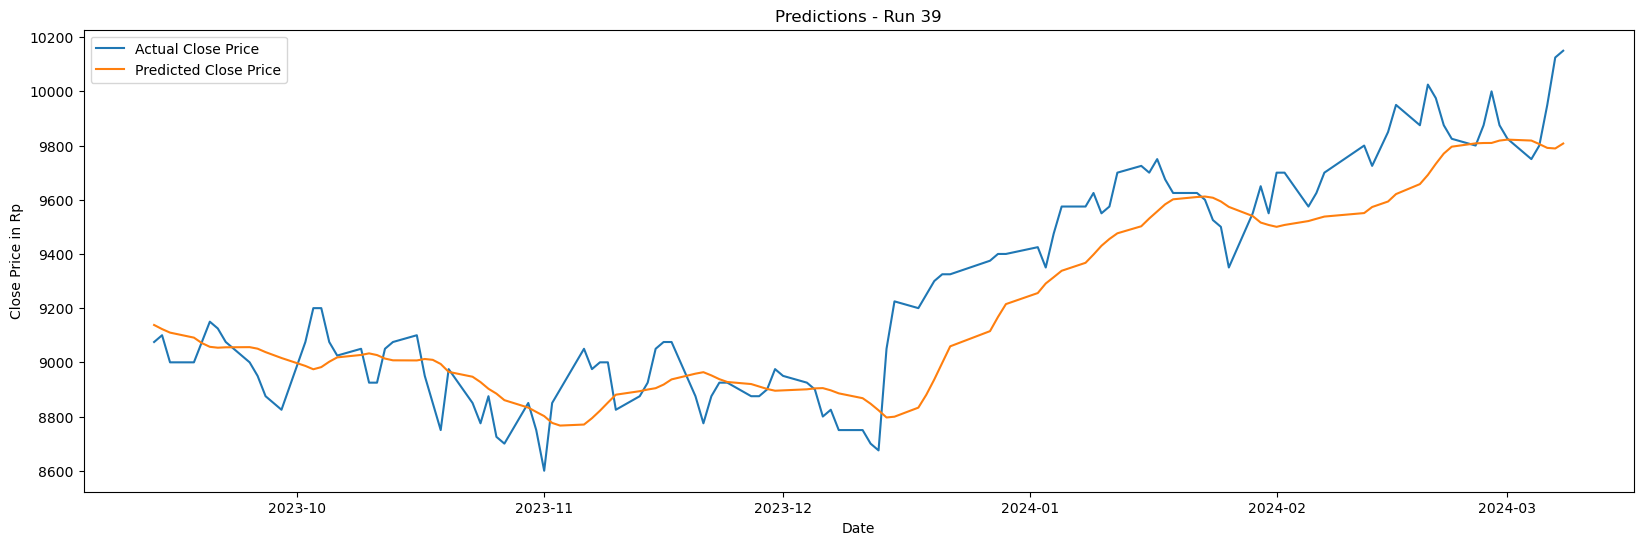

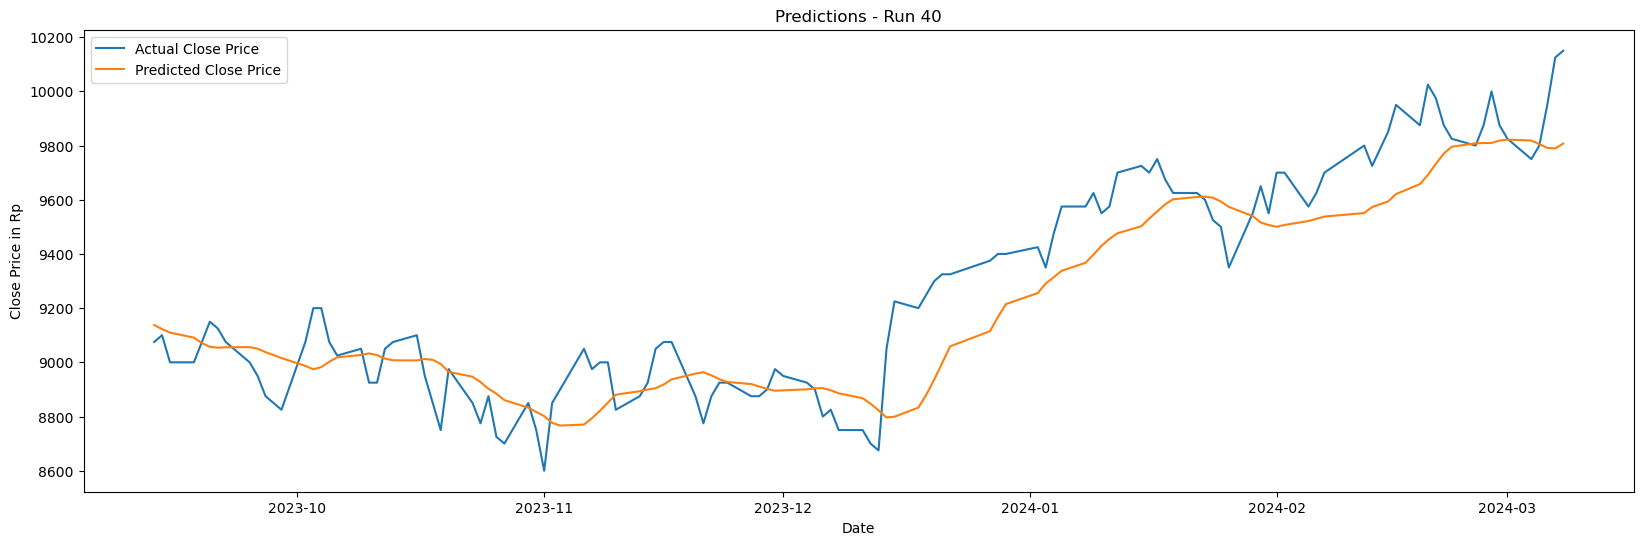

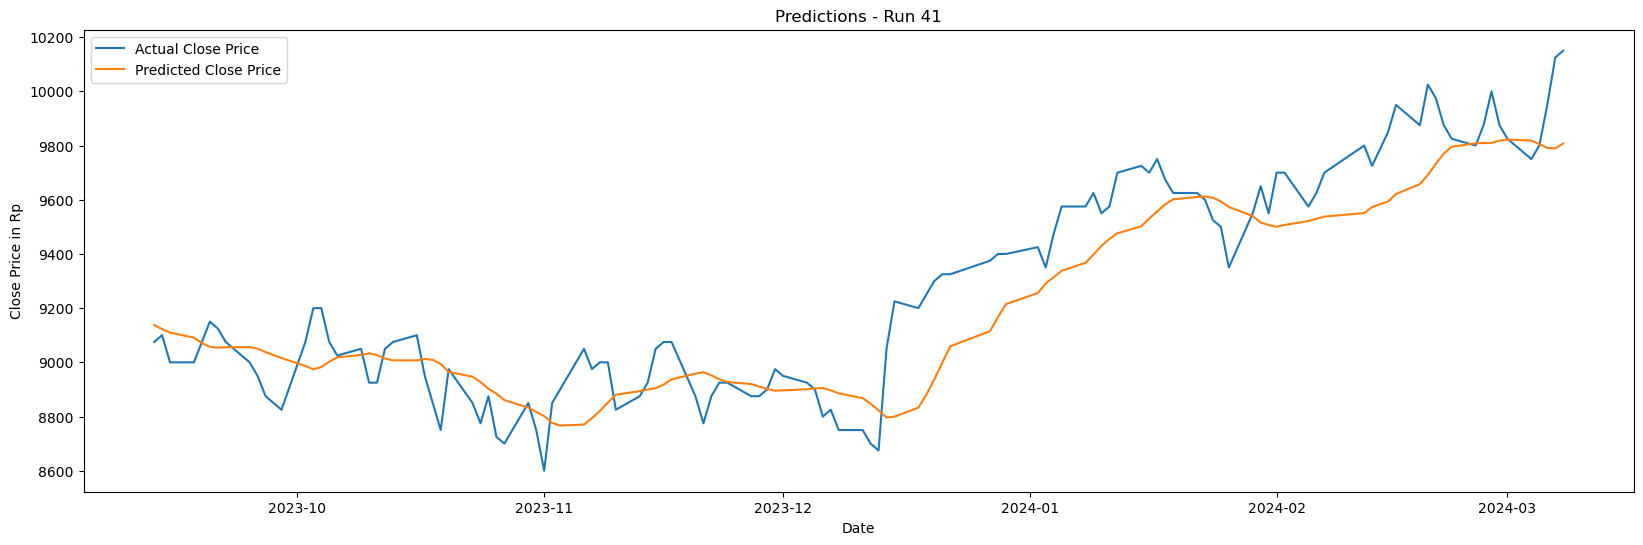

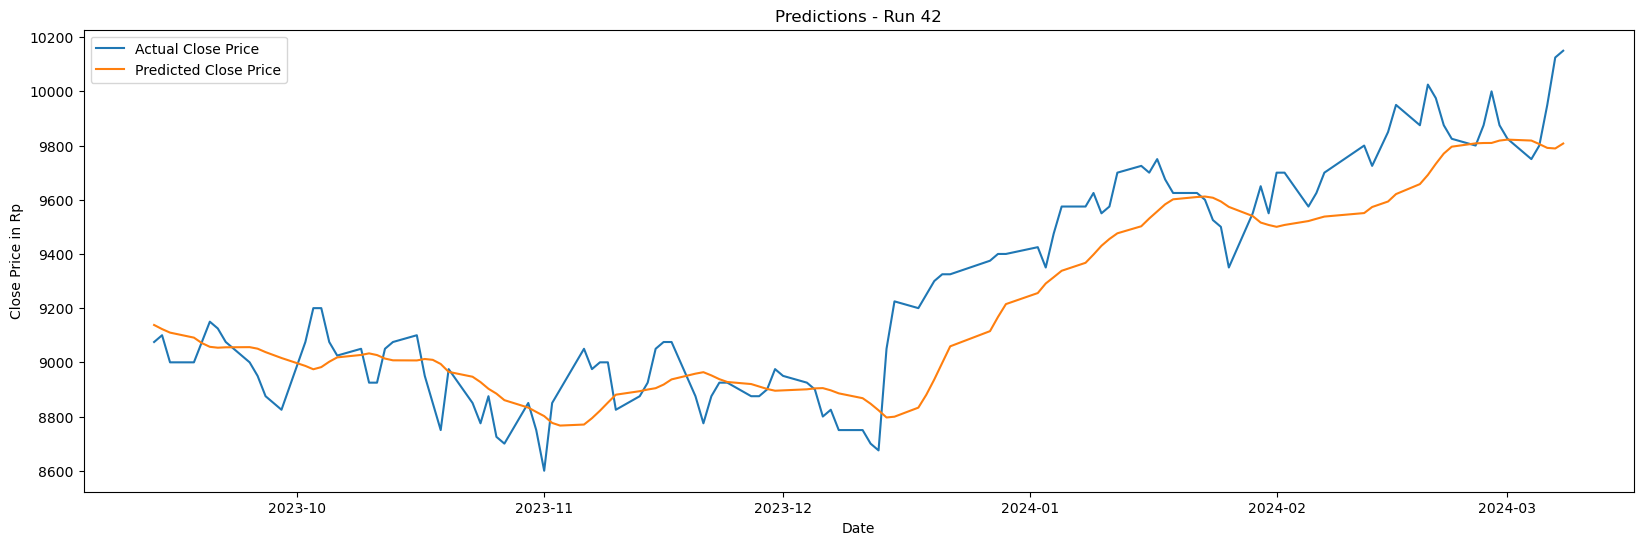

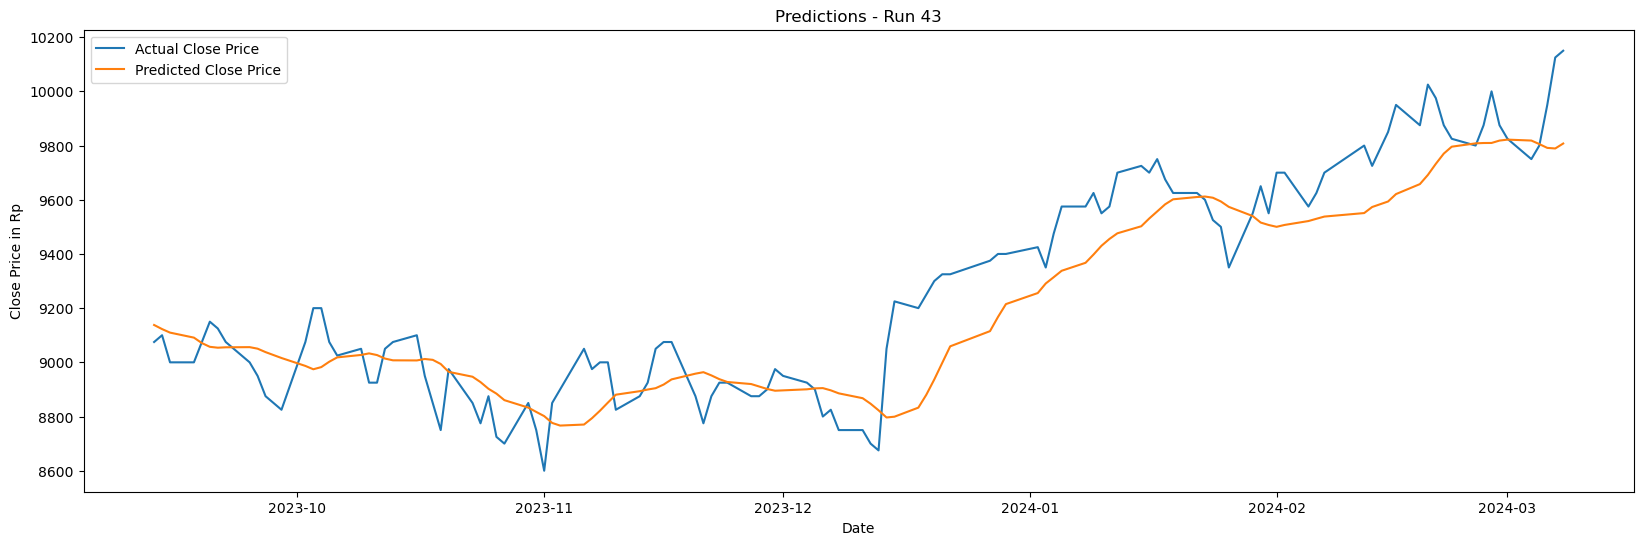

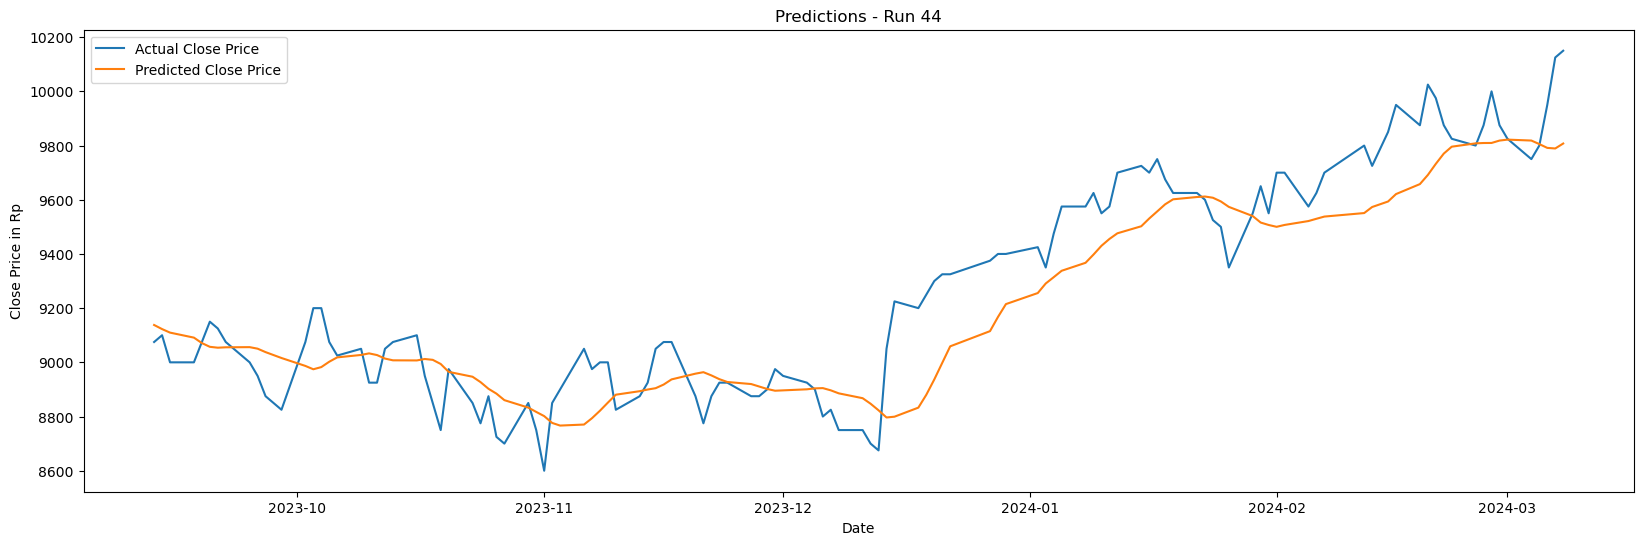

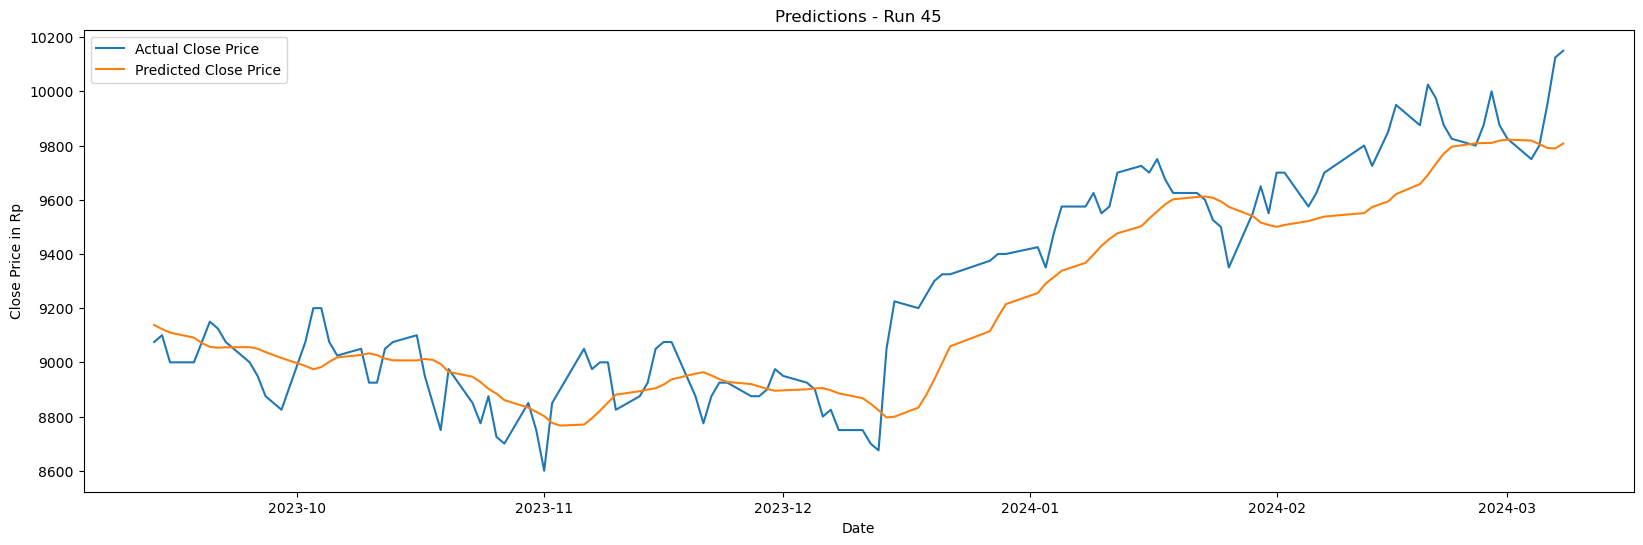

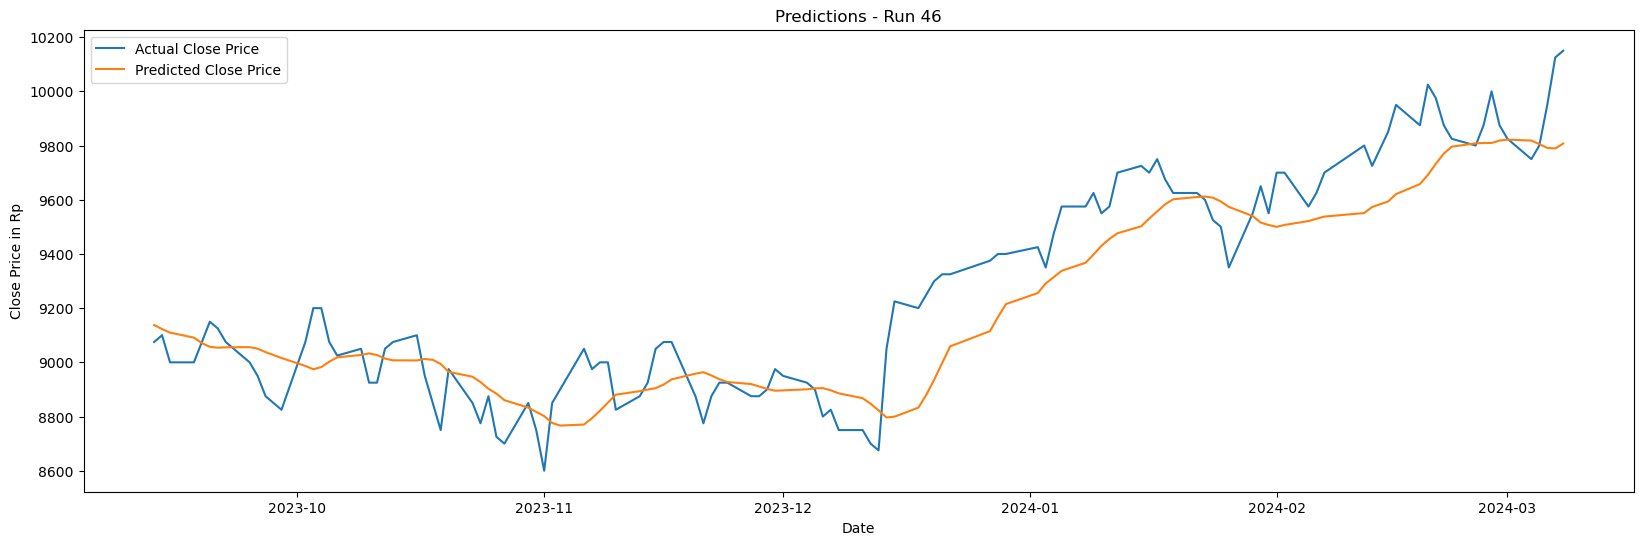

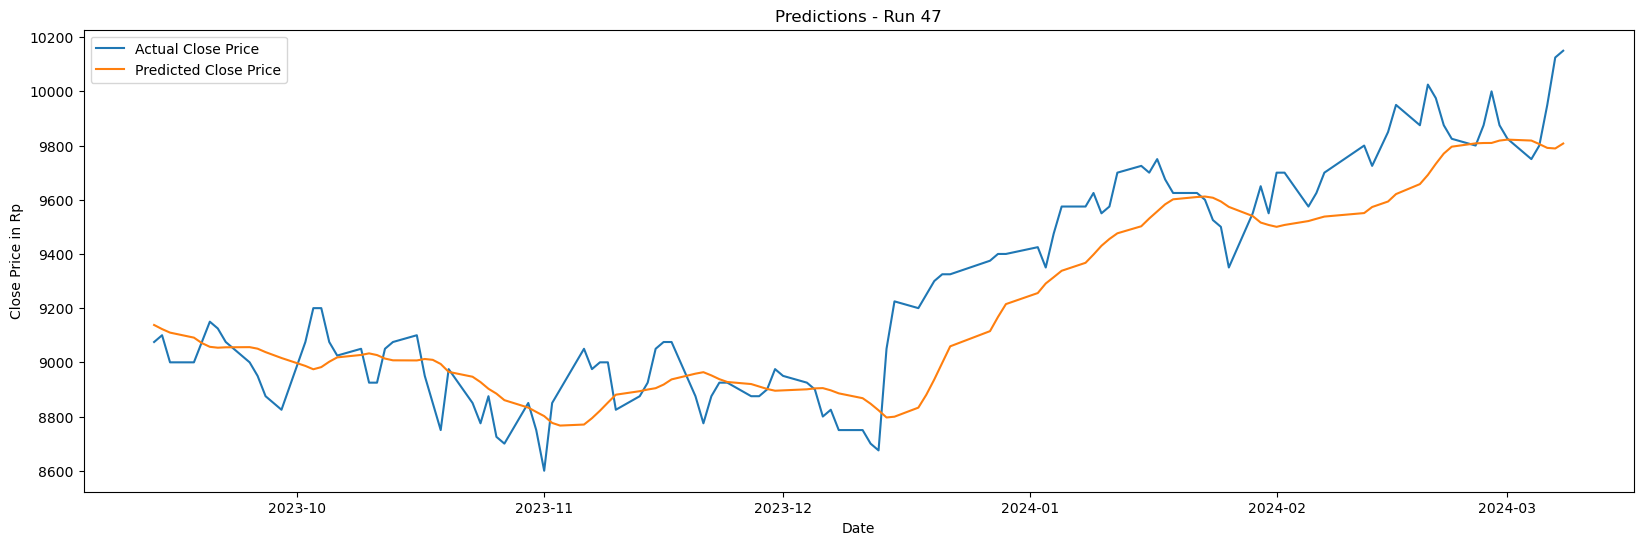

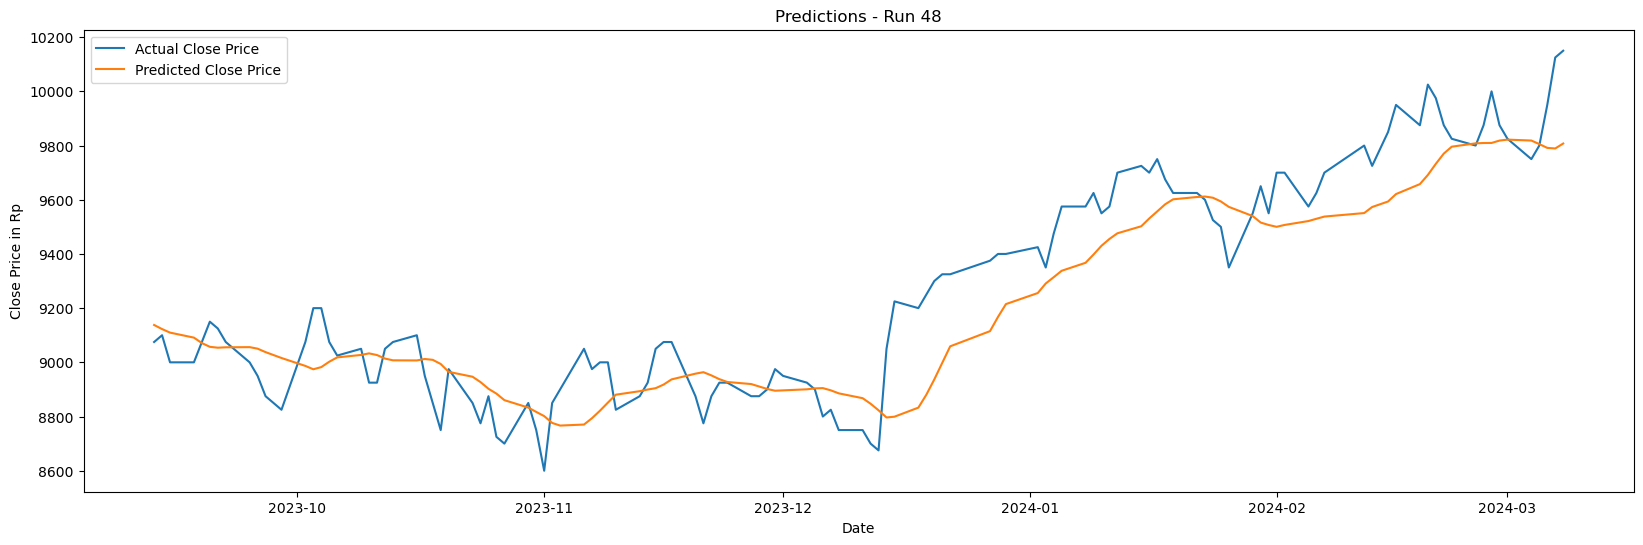

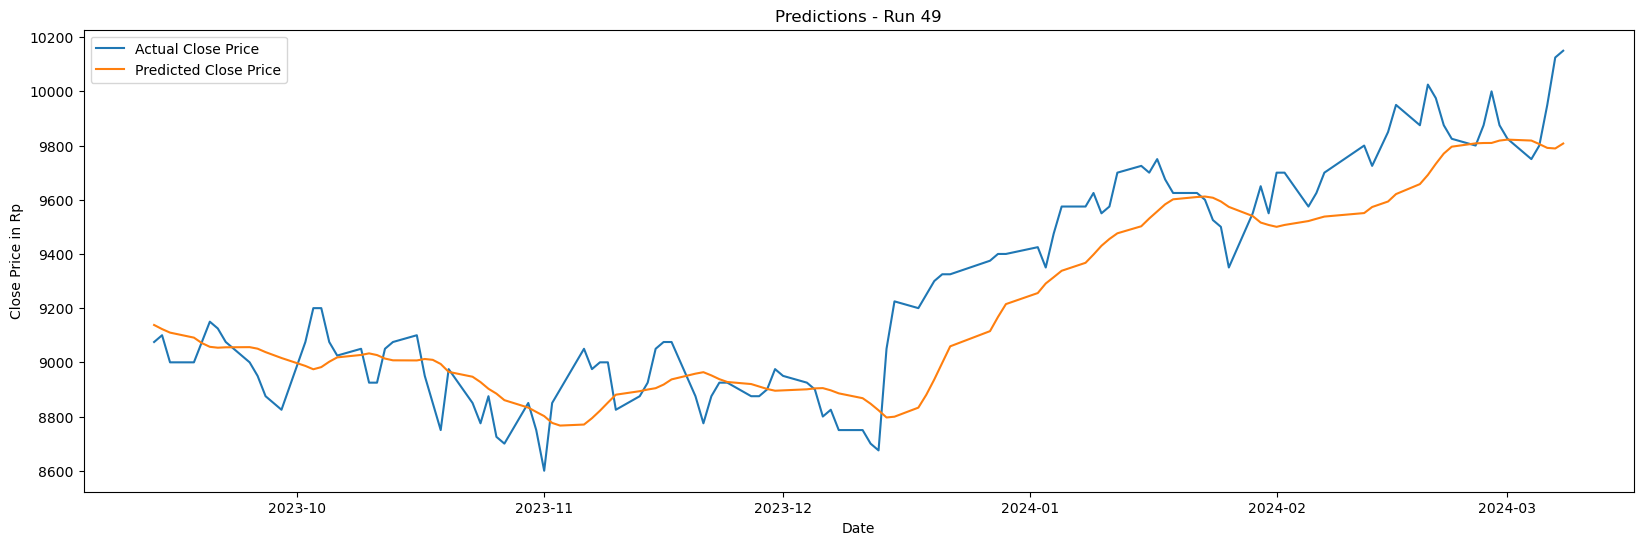

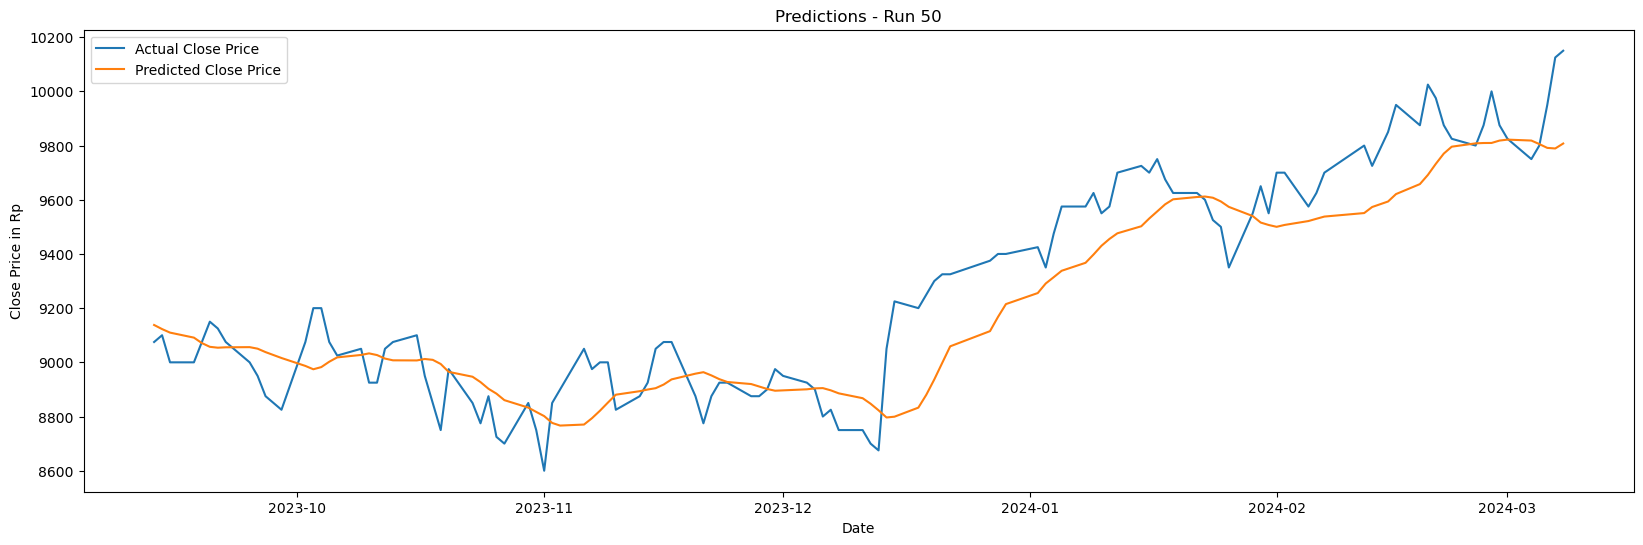

In [22]:
for i in range(50):
    # Plot predictions
    plt.figure(figsize=(20,6))
    plt.plot(data.index[training_data_len:], data['Close'][training_data_len:], label='Actual Close Price')
    plt.plot(data.index[training_data_len:], predictions, label='Predicted Close Price')
    plt.title(f'Predictions - Run {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Close Price in Rp')
    plt.legend()
    plt.show()

In [27]:
# Ambil kolom 'Average_Prediction'
average_prediction = results_df['Average_Prediction'].copy()

# Hapus 2 baris terakhir dari 'average_prediction'
average_prediction = average_prediction.iloc[:-2]

# Buat DataFrame baru dengan kolom 'Average_Prediction'
new_dataframe = pd.DataFrame(average_prediction, columns=['Average_Prediction'])

# Atur kolom 'Date' dari data sebagai indeks
new_dataframe.index = data.index[training_data_len:]

# Tambahkan kolom 'Actual' dari data asli
new_dataframe['Actual'] = data['Close'][training_data_len:]  

# Tampilkan DataFrame baru
print(new_dataframe)

            Average_Prediction   Actual
Date                                   
2023-09-13         9152.782520   9075.0
2023-09-14         9139.296133   9100.0
2023-09-15         9127.673945   9000.0
2023-09-18         9111.160703   9000.0
2023-09-19         9093.234453   9075.0
...                        ...      ...
2024-03-04         9757.133613   9750.0
2024-03-05         9747.130059   9800.0
2024-03-06         9736.462109   9950.0
2024-03-07         9736.110879  10125.0
2024-03-08         9753.150742  10150.0

[121 rows x 2 columns]


In [28]:
# Save DataFrame to CSV with header
new_dataframe.to_csv('BBCALSTMvsActualW100.csv', header=True)

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error

def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Fetch LSTM's Prediction (Average_Prediction) and the Actual data
predictions = new_dataframe['Average_Prediction']
actual = new_dataframe['Actual']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predictions))

# Calculate MAPE
mape = calculate_mape(actual, predictions)

# Print RMSE & MAPE
print('RMSE:', rmse)
print('MAPE:', mape)

RMSE: 175.97618525234876
MAPE: 1.5547146458046632


/var/folders/dx/r9qzc02n76vb2zj4g6731w_r0000gn/T/ipykernel_34300/2582833144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


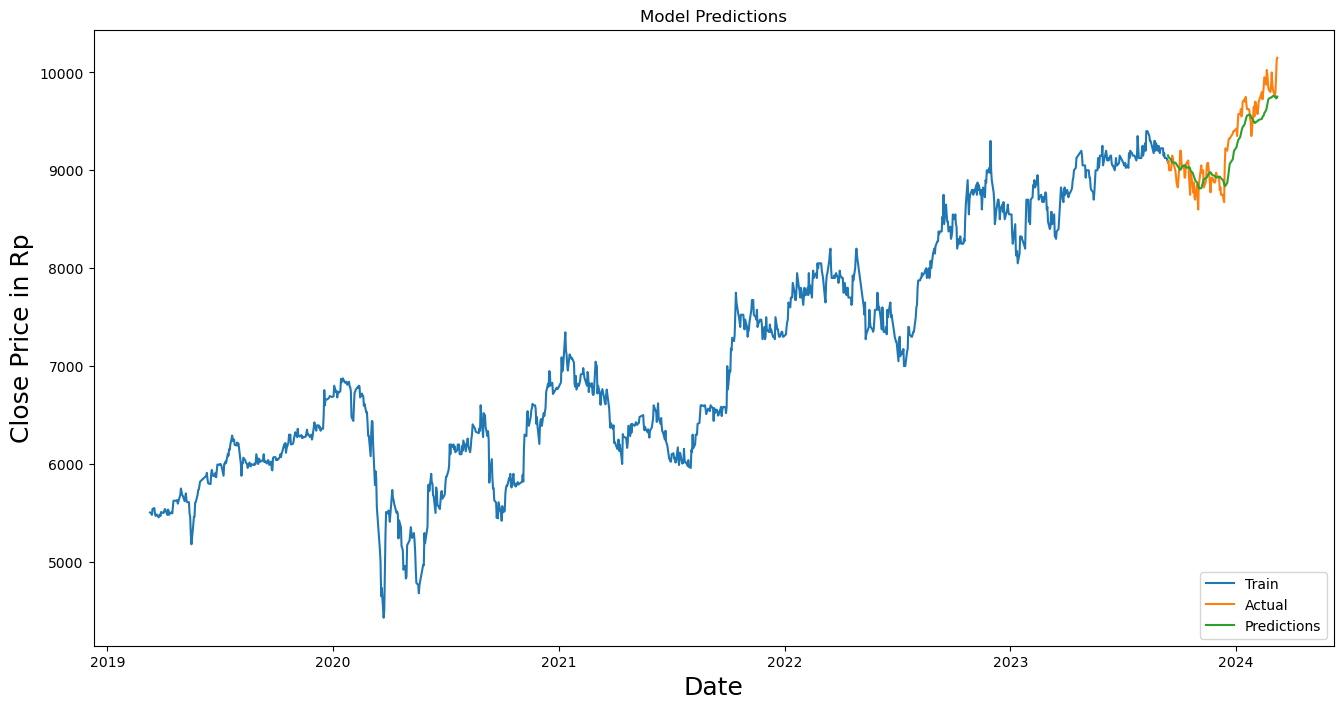

In [30]:
# Fetch testing and training data
train = data[:training_data_len]
valid = data[training_data_len:]

# Add 'Predictions'
valid['Predictions'] = predictions

# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual and prediction
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predictions')

# Add legend
plt.legend(loc='lower right')
plt.show()

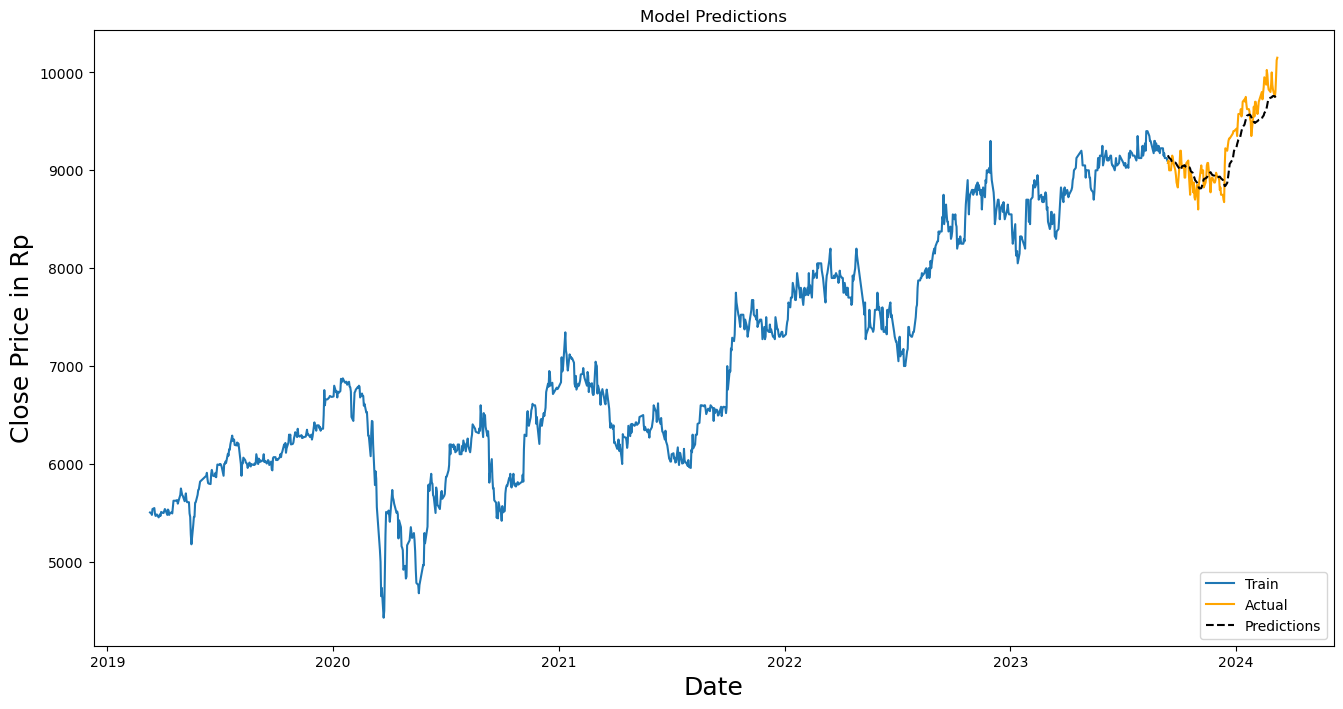

In [31]:
# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual data
plt.plot(valid.index, valid['Close'], label='Actual', linestyle='-', color='orange')

# Plot prediction data
plt.plot(valid.index, valid['Predictions'], label='Predictions', linestyle='--', color='black')

# Add legend
plt.legend(loc='lower right')
plt.show()